# Convolutional Autoencoder 2

Sticking with the MNIST dataset, let's improve our autoencoder's performance using convolutional layers. Again, loading modules and the data.

In [3]:
%matplotlib inline

import numpy as np
import tensorflow as tf 
import matplotlib.pyplot as plt
import os 
import matplotlib.pyplot as plt
from matplotlib.image import imread
from scipy.misc import imsave
from scipy.misc import imresize
import numpy as np
from numpy import genfromtxt
import tensorflow as tf
from PIL import Image
import pickle
# from tensorflow_vgg import vgg16|
import collections
import time
import math

# Import GEI dataset 

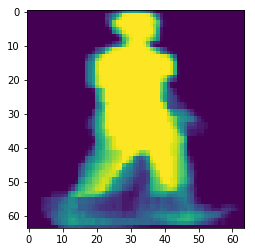

In [2]:
img = imread('{}'.format(os.path.join('OULP-C1V2_Pack/GEI/OULP-GEI-(224x224)-15f/Seq00/0000024', '0000024_55_GEI_15f.png')))
img = imresize(img, [64, 64], interp='nearest')
plt.imshow(img)
plt.show()

In [45]:
# Create Training Data
path = 'OULP-C1V2_Pack/GEI/OULP-GEI-(224x224)/Seq01'
Seq_15f_list = os.listdir(path)
Seq_15f_list.remove('.DS_Store')

Seq = []
for each_seq in Seq_15f_list:
    seq_path = os.path.join(path, each_seq)
    GEI = []
    for each_GEI in os.listdir(seq_path):
        img = imread('{}'.format(os.path.join(seq_path, each_GEI)))
        img = imresize(img, [64, 64], interp='nearest')
        GEI.append(img)
    Seq.append(np.array(GEI))
Seq = np.array(Seq)

In [46]:
with open('../gait_data/OULP_GEI/codes', 'wb') as f:
    np.save(f, Seq)

# Checkpoint 1

In [99]:
# gallery_15f = np.load(open(r'../gait_data/OULP_GEI/GEI64x64_15f_Seq00', mode='rb'))
# probe_15f = np.load(open(r'../gait_data/OULP_GEI/GEI64x64_15f_Seq01', mode='rb'))
gallery_full = np.load(open(r'../gait_data/OULP_GEI/GEI64x64_full_Seq00', mode='rb'))
probe_full = np.load(open(r'../gait_data/OULP_GEI/GEI64x64_full_Seq01', mode='rb'))

In [100]:
gallery_full = gallery_full/float(255)
probe_full = probe_full/float(255)

<br><br><br><br><br><br><br><br><br>

# Auto_Encoder 1: 55''-65''
### 先试full-full

In [143]:
# Train X
train_x = np.concatenate([gallery_full[:2573, 0], probe_full[:2573, 0]], axis=0)
train_x = np.reshape(train_x, [train_x.shape[0], train_x.shape[1], train_x.shape[2], 1])
# Train Y
train_y = np.concatenate([gallery_full[:2573, 1], probe_full[:2573, 1]], axis=0)
train_y = np.reshape(train_x, [train_x.shape[0], train_x.shape[1], train_x.shape[2], 1])
print('train_x', train_x.shape, 'train_y', train_y.shape)

# Val X
val_x = gallery_full[2573:, 0]
val_x = np.reshape(val_x, [val_x.shape[0], val_x.shape[1], val_x.shape[2], 1])
# Val Y
val_y = gallery_full[2573:, 1]
val_y = np.reshape(val_y, [val_y.shape[0], val_y.shape[1], val_y.shape[2], 1])
print('val_x', val_x.shape, 'val_y', val_y.shape)

# Test X
test_x = probe_full[2573:, 0]
test_x = np.reshape(test_x, [test_x.shape[0], test_x.shape[1], test_x.shape[2], 1])
# Test Y
test_y = probe_full[2573:, 1]
test_y = np.reshape(test_x, [test_x.shape[0], test_x.shape[1], test_x.shape[2], 1])
print('test_x', test_x.shape, 'test_y', test_y.shape)

train_x (5146, 64, 64, 1) train_y (5146, 64, 64, 1)
val_x (573, 64, 64, 1) val_y (573, 64, 64, 1)
test_x (573, 64, 64, 1) test_y (573, 64, 64, 1)


# Create Graph

In [144]:
def build_inputs_outputs():
    inputs_1 = tf.placeholder(tf.float32, (None, 64, 64, 1), name='inputs_1')
    targets_1 = tf.placeholder(tf.float32, (None, 64, 64, 1), name='targets_1')
    
    return inputs_1, targets_1

def conv_layer(inputs_, conv_name, pool_name, bn_name, relu_name, add_bacth_norm=True, is_training=True, out_dim=1, 
               kern_size=(2,2), conv_strides=(1,1), pool_size=(2,2), pool_strides=(2,2), keep_prob=0.5):
    ### Encoder
    # e.g. out_dim: 8; kern_size: (3,3); pool_size: (2,2); strides: (2,2);
    conv = tf.layers.conv2d(inputs_, out_dim, kern_size, strides=conv_strides, padding='same', activation=None,
                            name=conv_name)
    # Now 28x28x
    if add_bacth_norm:
        conv = tf.layers.batch_normalization(conv, training=is_training, name=bn_name)
        
    conv = tf.nn.relu(conv, name=relu_name)
        
    maxpool = tf.layers.max_pooling2d(conv, pool_size, pool_strides, padding='same', name=pool_name)
    
    maxpool = tf.layers.dropout(maxpool, rate=keep_prob)

    return maxpool

#     # Now 14x14x16
#     conv2 = tf.layers.conv2d(maxpool1, 8, (3,3), padding='same', activation=tf.nn.relu)
#     # Now 14x14x8
#     maxpool2 = tf.layers.max_pooling2d(conv2, (2,2), (2,2), padding='same')
#     # Now 7x7x8
#     conv3 = tf.layers.conv2d(maxpool2, 8, (3,3), padding='same', activation=tf.nn.relu)
#     # Now 7x7x8
#     encoded = tf.layers.max_pooling2d(conv3, (2,2), (2,2), padding='same')
#     # Now 4x4x8

def deconv_layer(encoded, up_name, conv_name, bn_name, relu_name, add_batch_norm=True, is_training=True, 
                 up_size=(2,2), out_dim=1, kern_size=(2,2), conv_strides=(1,1), keep_prob=0.5):
    ### Decoder
    upsample = tf.image.resize_nearest_neighbor(encoded, up_size, name=up_name) # up_size: e.g.(7,7)
    # Now 7x7x8 kern_size: (3, 3)
    conv = tf.layers.conv2d(upsample, out_dim, kern_size, strides=conv_strides, padding='same', activation=None, 
                            name=conv_name) 
    
    if add_batch_norm:
        conv = tf.layers.batch_normalization(conv, training=is_training, name=bn_name)
    
    conv = tf.nn.relu(conv, name=relu_name)
    
    conv = tf.layers.dropout(conv, rate=keep_prob)
    
    return conv

#     # Now 7x7x8
#     upsample2 = tf.image.resize_nearest_neighbor(conv4, (14,14))
#     # Now 14x14x8
#     conv5 = tf.layers.conv2d(upsample2, 8, (3,3), padding='same', activation=tf.nn.relu)
#     # Now 14x14x8
#     upsample3 = tf.image.resize_nearest_neighbor(conv5, (28,28))
#     # Now 28x28x8
#     conv6 = tf.layers.conv2d(upsample3, 16, (3,3), padding='same', activation=tf.nn.relu)
#     # Now 28x28x16

def output_layer(conv, logits_name, bn_name, decoded_name, add_batch_norm=True, is_training=True, 
                 out_dim=1, kern_size=(3,3), conv_strides=(1,1)):
    logits = tf.layers.conv2d(conv, out_dim, kern_size, strides=conv_strides, padding='same', activation=None, 
                              name=logits_name)
    
    if add_batch_norm:
        conv = tf.layers.batch_normalization(conv, training=is_training, name=bn_name)
    #Now 28x28x1
    decoded = tf.nn.sigmoid(logits, name=decoded_name)
    
    return logits, decoded

In [145]:
def build_graph(kern_size, conv_strides, pool_size, pool_strides, de_kern_size, 
                de_conv_strides, out_kern_size, out_strides, up_size=[(16,16), (32,32), (64,64)], is_training=True):
    
    # reset graph
    tf.reset_default_graph()
    
    with tf.name_scope('inputs_targets'):
        inputs_1, targets_1 = build_inputs_outputs()
    
    keep_p = tf.placeholder(tf.float32, name="keep_prob")
    
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    with tf.name_scope('conv_layers'):
        
        maxpool_1 = conv_layer(inputs_1, 'conv_1', 'pool_1', 'bn_1', 'relu_1', add_bacth_norm=False, 
                               is_training=is_training, out_dim=16, kern_size=kern_size, conv_strides=conv_strides, 
                               pool_size=pool_size, pool_strides=pool_strides, keep_prob=keep_p)
        
        maxpool_2 = conv_layer(maxpool_1, 'conv_2', 'pool_2', 'bn_2', 'relu_2', add_bacth_norm=True, 
                               is_training=is_training, out_dim=8, kern_size=kern_size, conv_strides=conv_strides, 
                               pool_size=pool_size, pool_strides=pool_strides, keep_prob=keep_p)
        
        maxpool_3 = conv_layer(maxpool_2, 'conv_3', 'pool_3', 'bn_3', 'relu_3', add_bacth_norm=True, 
                               is_training=is_training, out_dim=8, kern_size=kern_size, conv_strides=conv_strides, 
                               pool_size=pool_size, pool_strides=pool_strides, keep_prob=keep_p)
        
    with tf.name_scope('deconv_layers'):
        
        deconv_1 = deconv_layer(maxpool_3, 'up_1', 'deconv_1', 'de_bn_1', 'de_relu_1', add_batch_norm=True, 
                              is_training=is_training, up_size=up_size[0], out_dim=8, kern_size=de_kern_size,
                              conv_strides=de_conv_strides, keep_prob=keep_p)
        
        deconv_2 = deconv_layer(deconv_1, 'up_2', 'deconv_2', 'de_bn_2', 'de_relu_2', add_batch_norm=True, 
                              is_training=is_training, up_size=up_size[1], out_dim=8, kern_size=de_kern_size,
                              conv_strides=de_conv_strides, keep_prob=keep_p)
        
        deconv_3 = deconv_layer(deconv_2, 'up_3', 'deconv_3', 'de_bn_3', 'de_relu_3', add_batch_norm=True, 
                              is_training=is_training, up_size=up_size[2], out_dim=16, kern_size=de_kern_size,
                              conv_strides=de_conv_strides, keep_prob=keep_p)
        
    with tf.name_scope('output_layer'):
        
        logits, decoded = output_layer(deconv_3, 'logits', 'bn', 'decoded', add_batch_norm=True, is_training=is_training, 
                                       out_dim=1, kern_size=out_kern_size, conv_strides=out_strides)
        
    loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_1, logits=logits, name='loss')
    cost = tf.reduce_mean(loss, name='cost')
    opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
    with tf.name_scope('saver'):
        saver = tf.train.Saver()
        
#     merged = tf.summary.merge_all()
    
    export_nodes = ['inputs_1', 'targets_1', 'maxpool_1', 'maxpool_2', 'maxpool_3', 'deconv_1', 'deconv_2', 
                    'deconv_3', 'logits', 'decoded', 'loss', 'cost', 'opt', 'saver', 'learning_rate', 'keep_p']
    
    Graph = collections.namedtuple('Graph', export_nodes)
    local_dict = locals()
    graph = Graph(*[local_dict[each] for each in export_nodes])
    
    return graph

In [170]:
def get_batches(data, target, batch_size):
    n_batches = len(data)//batch_size
    data = data[:batch_size * n_batches]
    target = target[:batch_size * n_batches]
    for ii in range(0, batch_size*n_batches, batch_size):
        data_batch = data[ii:ii + batch_size]
        target_batch = target[ii:ii + batch_size]
        
        yield data_batch, target_batch
        
        
def cal_accuracy(decoded, target):
    error = abs(decoded - target)
    Acc = (np.sum(error <= 0.15)/(decoded.shape[0]*decoded.shape[1]*decoded.shape[2]*decoded.shape[3]))*100
    
    return Acc

In [171]:
error = np.random.rand(10,5,5,1)
np.sum(error >= 0.9)/100

0.29999999999999999

In [175]:
def train(model, epochs, save_string):

    with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
        sess.run(tf.global_variables_initializer())
        
        iteration = 1
        mean_val_loss = 0
        mean_val_acc = 0
        count_loss_not_decrease_epochs = 0
        count_acc_not_decrease_epochs = 0
        Last_val_loss = 0
        Last_val_acc = 0
        
        
        for e in range(epochs):
            for train_batch, target_batch in get_batches(train_x, train_y, batch_size):
                    
                start = time.time()
                
                feed_1 = {
                        model.inputs_1: train_batch, 
                        model.targets_1: target_batch,
                        model.keep_p: 0.5,
                        model.learning_rate: lr
                        }

                train_loss, _, decoded_img = sess.run([model.cost, model.opt, model.decoded], feed_dict=feed_1)
                
                train_acc = cal_accuracy(decoded_img, target_batch)
                
                if iteration%5==0:
                    end = time.time()
#                     acc = calculate_accuracy(sess, pred, target_batch, sq_length)
                    print(
                          "Epoch: {}/{},".format(e+1, epochs),' ',
                          "Iteration: {},".format(iteration),' ',
                          "Train loss: {:.3f},".format(train_loss),' '
                          "{:.1f}s /batch.".format((end-start)/5),' '
                          "Train Accuracy: %{:.3f}".format(train_acc) 
                    )
                                
                ##############################################################
                ######################## VALIDATION ##########################
                ##############################################################
                
                if iteration%25==0:
#                     training = True
                    validation_loss = []
                    validation_acc = []
                    
                    if batch_size >= len(val_x):
                        val_batch_size = len(val_x)
                    else: 
                        val_batch_size = batch_size
                        
#                     ii = 0
                    for ii, (val_batch, val_target_batch) in enumerate(get_batches(val_x, val_y, val_batch_size)):
#                         print(ii, len(val_x)//val_batch_size)
                        feed_2 = {
                                model.inputs_1: val_batch,
                                model.targets_1: val_target_batch,
                                model.keep_p: 1
#                                 model.learning_rate: lr
                                }
                        
                        val_loss, val_decoded_img, max_pool_3 = sess.run([model.cost, model.decoded, model.maxpool_3], 
                                                                          feed_dict=feed_2)
#                         print(val_loss, val_decoded_img)
                        val_acc = cal_accuracy(val_decoded_img, val_target_batch)
                        
                        validation_loss.append(val_loss)
                        validation_acc.append(val_acc)
                        
#                         ii += 1
                        
                        # plot out
#                         if ii == (len(val_x)//val_batch_size) - 1:
                        fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
                        in_imgs = val_target_batch[:10]
                        reconstructed = val_decoded_img[:10]

                        for images, row in zip([in_imgs, reconstructed], axes):
                            for img, ax in zip(images, row):
                                ax.imshow(img.reshape((64, 64)), cmap='Greys_r')
                                plt.show()
                                ax.get_xaxis().set_visible(True)
                                ax.get_yaxis().set_visible(True)

                        fig.tight_layout(pad=0.1)
                            
                    Last_val_loss = mean_val_loss
                    Last_val_acc = mean_val_acc
                    mean_val_loss = np.mean(np.array(validation_loss))
                    mean_val_acc = np.mean(np.array(validation_acc))
                    
                    print()
                    print("Validation loss: {:.3f},".format(mean_val_loss),' '
                          "Validation accuracy: {:.3f},".format(mean_val_acc),' '
                          "maxpool_3.shape: {}.".format(max_pool_3[0].shape))
                    print()
                    
                iteration += 1
                
#             # Early stopping  
#             if mean_val_Acc - Last_val_Acc <= -0.3:
#                 count_Acc_not_increase_epochs += 1
#             if Last_val_loss - mean_val_loss <= -0.01:
#                 count_loss_not_decrease_epochs += 1
                
#             if mean_val_Acc - Last_val_Acc <= -2:
#                 break
#             if count_Acc_not_increase_epochs >= 10:
#                 break
#             if count_loss_not_decrease_epochs >= 10:
#                 break
                
        model.saver.save(sess, r"{}".format(save_string))

mkdir: checkpoints_view_invariant: File exists
Epoch: 1/3000,   Iteration: 5,   Train loss: 0.590,  0.2s /batch.  Train Accuracy: %22.717
Epoch: 1/3000,   Iteration: 10,   Train loss: 0.542,  0.2s /batch.  Train Accuracy: %24.607
Epoch: 1/3000,   Iteration: 15,   Train loss: 0.501,  0.2s /batch.  Train Accuracy: %27.317
Epoch: 1/3000,   Iteration: 20,   Train loss: 0.458,  0.2s /batch.  Train Accuracy: %30.798
Epoch: 1/3000,   Iteration: 25,   Train loss: 0.426,  0.2s /batch.  Train Accuracy: %38.167


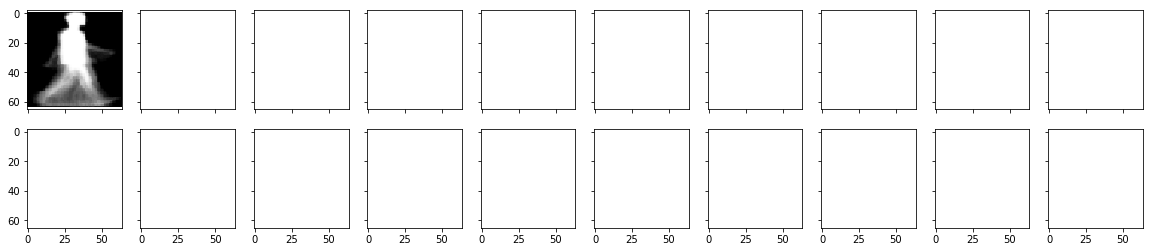

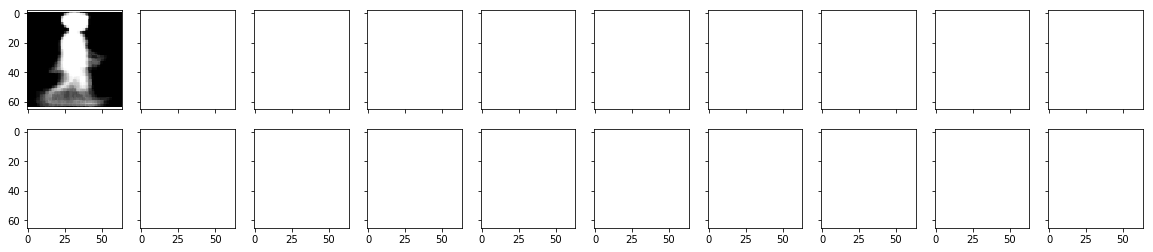

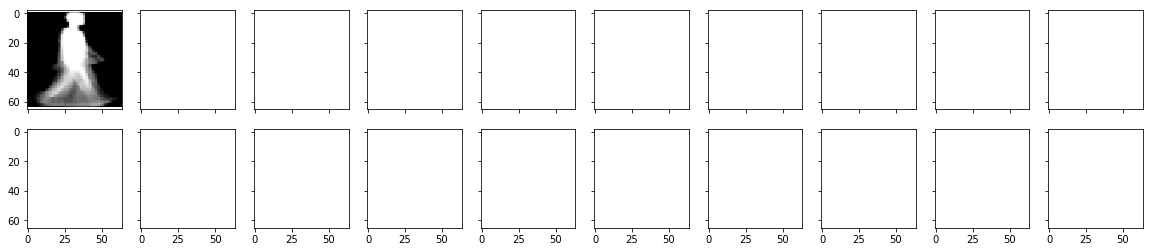

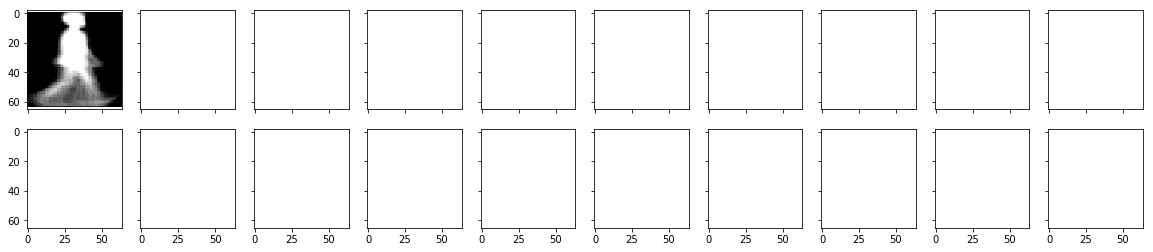

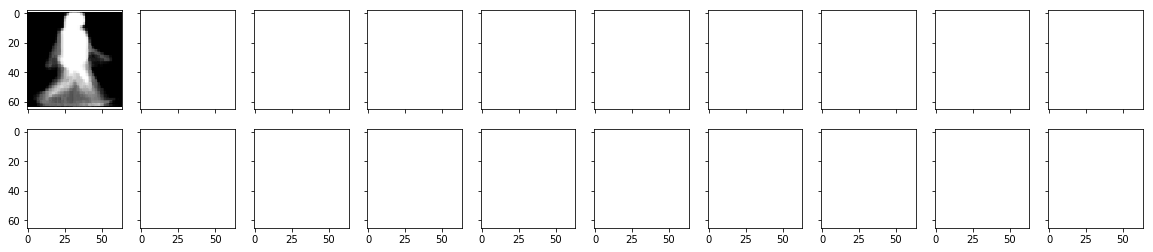

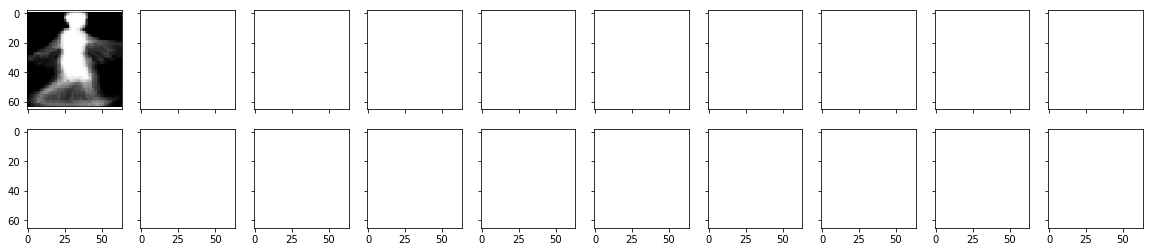

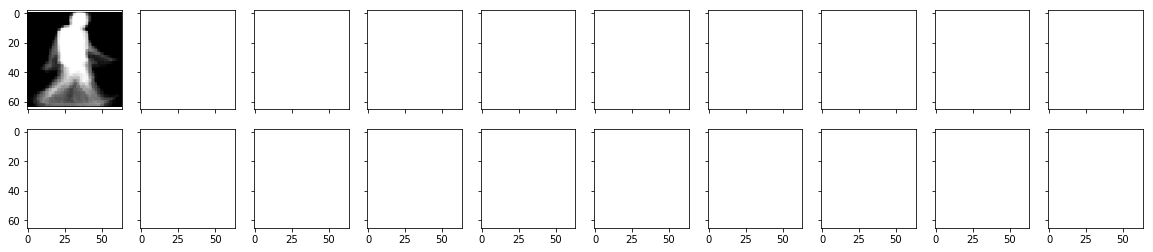


Validation loss: 0.429,  Validation accuracy: 35.996,  maxpool_3.shape: (8, 8, 8).

Epoch: 1/3000,   Iteration: 30,   Train loss: 0.397,  0.2s /batch.  Train Accuracy: %46.833
Epoch: 1/3000,   Iteration: 35,   Train loss: 0.381,  0.2s /batch.  Train Accuracy: %55.480
Epoch: 1/3000,   Iteration: 40,   Train loss: 0.367,  0.2s /batch.  Train Accuracy: %61.502
Epoch: 1/3000,   Iteration: 45,   Train loss: 0.344,  0.2s /batch.  Train Accuracy: %64.489
Epoch: 1/3000,   Iteration: 50,   Train loss: 0.336,  0.2s /batch.  Train Accuracy: %67.076


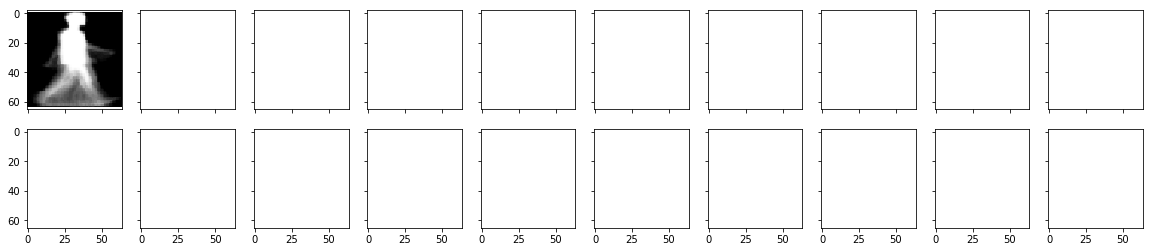

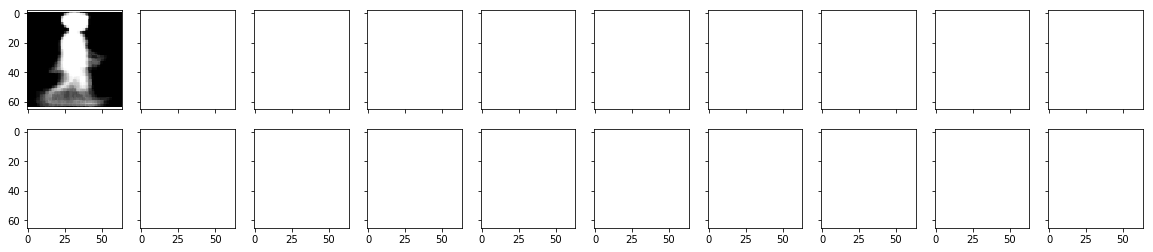

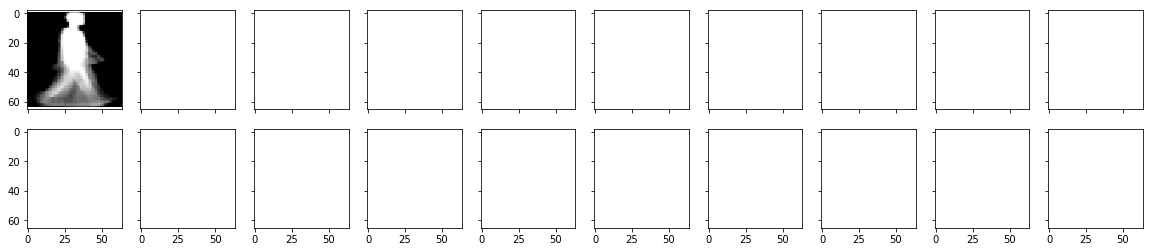

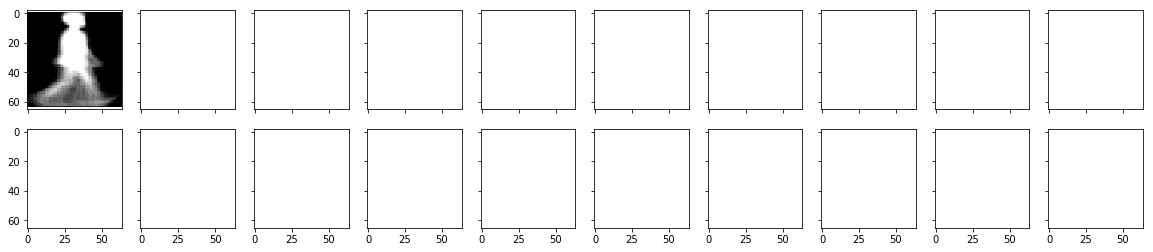

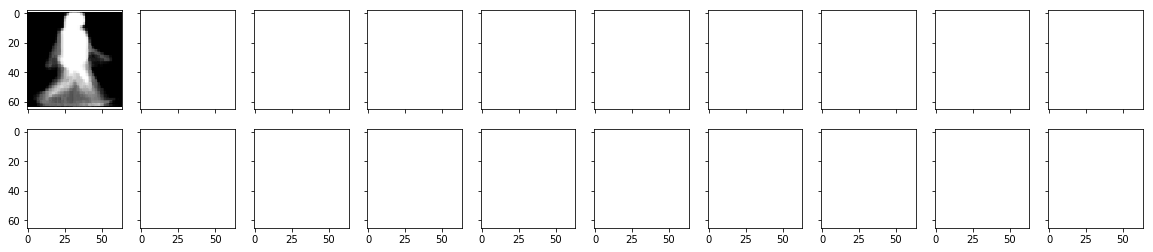

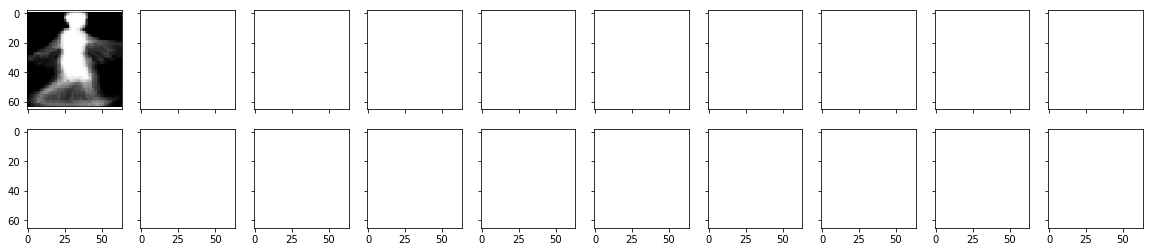

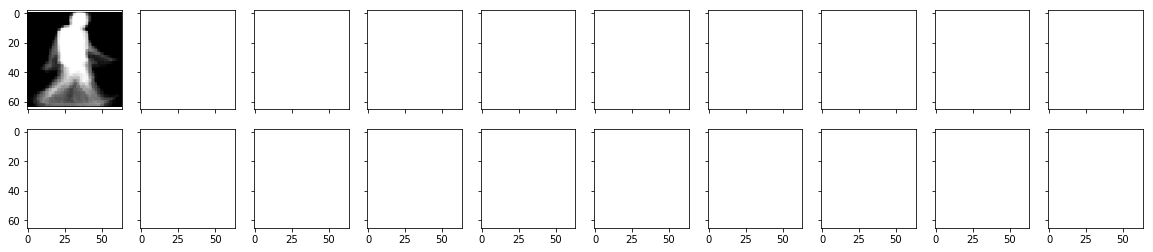


Validation loss: 0.343,  Validation accuracy: 62.906,  maxpool_3.shape: (8, 8, 8).

Epoch: 1/3000,   Iteration: 55,   Train loss: 0.328,  0.2s /batch.  Train Accuracy: %69.010
Epoch: 1/3000,   Iteration: 60,   Train loss: 0.319,  0.2s /batch.  Train Accuracy: %72.047
Epoch: 2/3000,   Iteration: 65,   Train loss: 0.309,  0.2s /batch.  Train Accuracy: %74.245
Epoch: 2/3000,   Iteration: 70,   Train loss: 0.309,  0.2s /batch.  Train Accuracy: %76.407
Epoch: 2/3000,   Iteration: 75,   Train loss: 0.306,  0.2s /batch.  Train Accuracy: %78.187


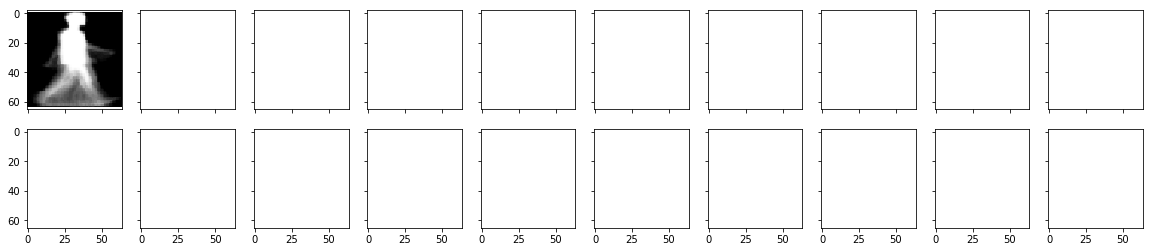

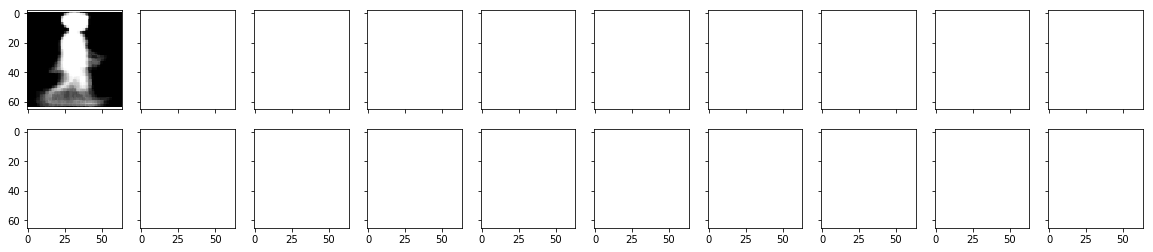

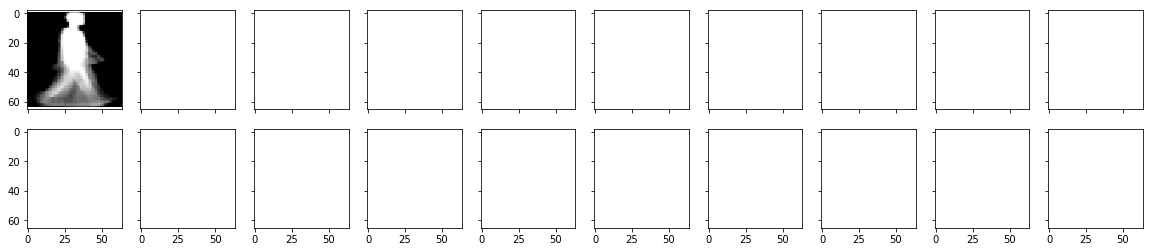

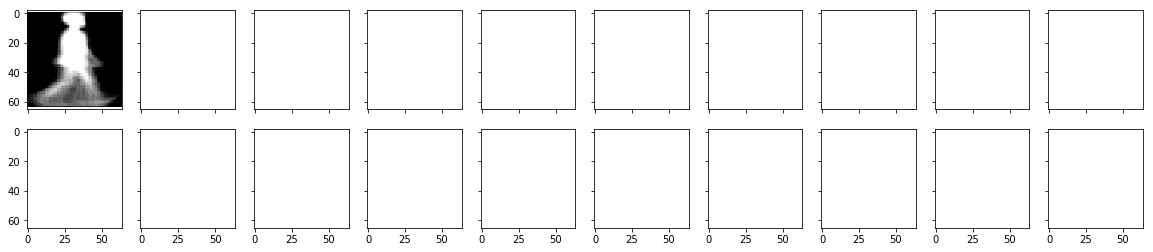

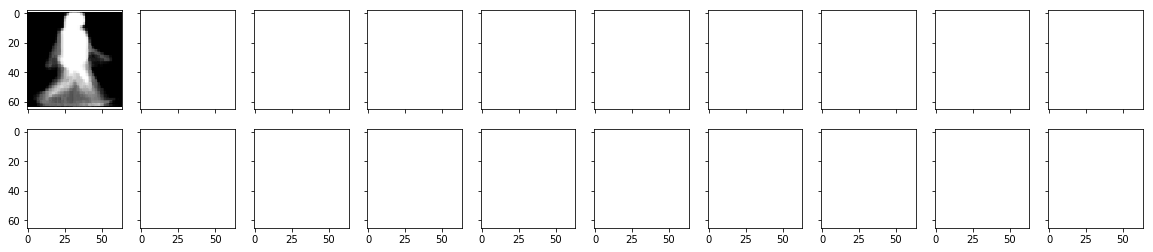

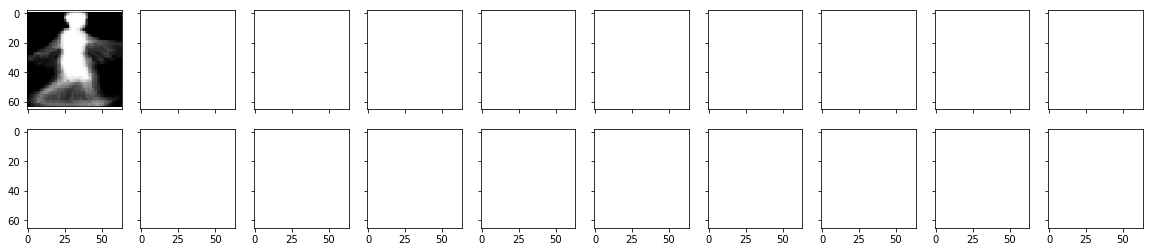

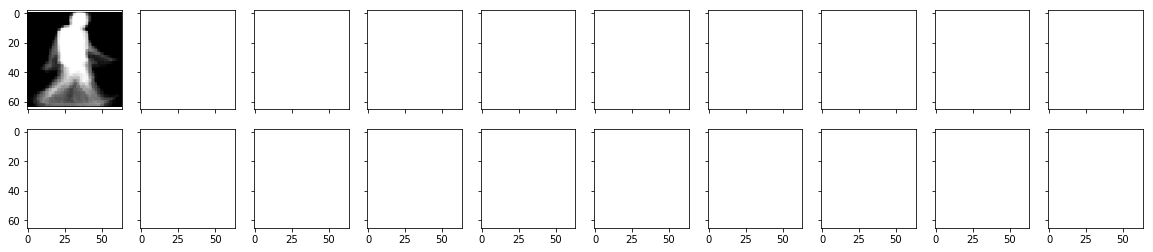


Validation loss: 0.305,  Validation accuracy: 73.899,  maxpool_3.shape: (8, 8, 8).

Epoch: 2/3000,   Iteration: 80,   Train loss: 0.298,  0.2s /batch.  Train Accuracy: %79.852
Epoch: 2/3000,   Iteration: 85,   Train loss: 0.294,  0.2s /batch.  Train Accuracy: %80.195
Epoch: 2/3000,   Iteration: 90,   Train loss: 0.289,  0.2s /batch.  Train Accuracy: %82.315
Epoch: 2/3000,   Iteration: 95,   Train loss: 0.287,  0.2s /batch.  Train Accuracy: %83.169
Epoch: 2/3000,   Iteration: 100,   Train loss: 0.294,  0.2s /batch.  Train Accuracy: %84.810


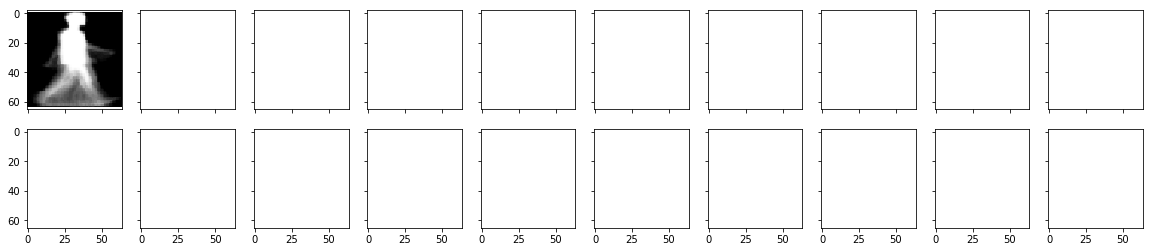

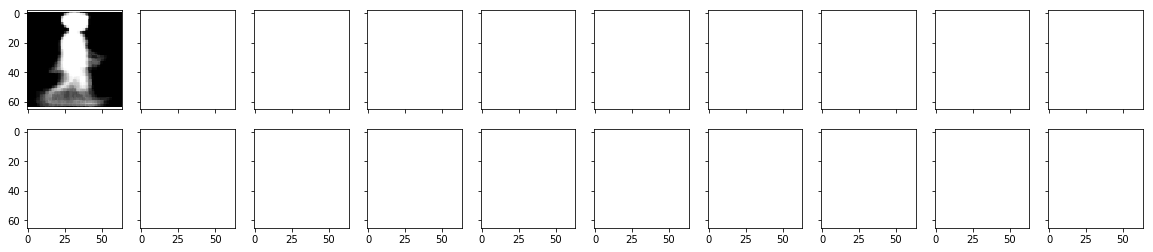

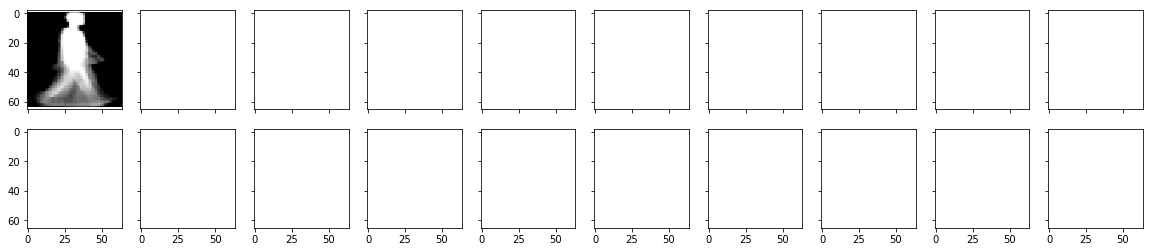

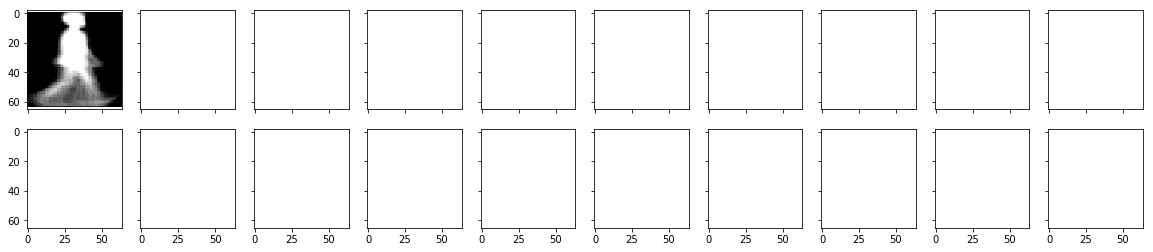

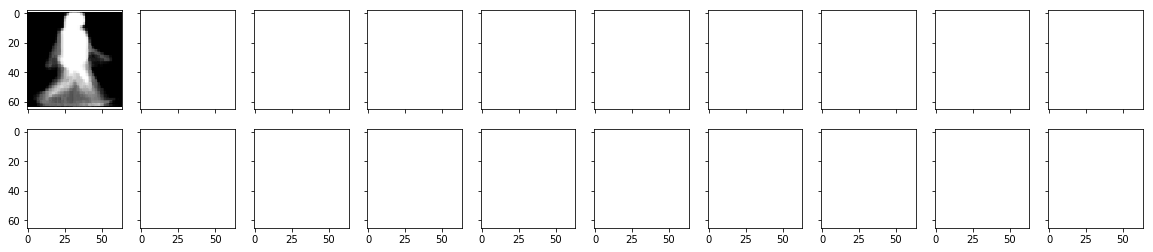

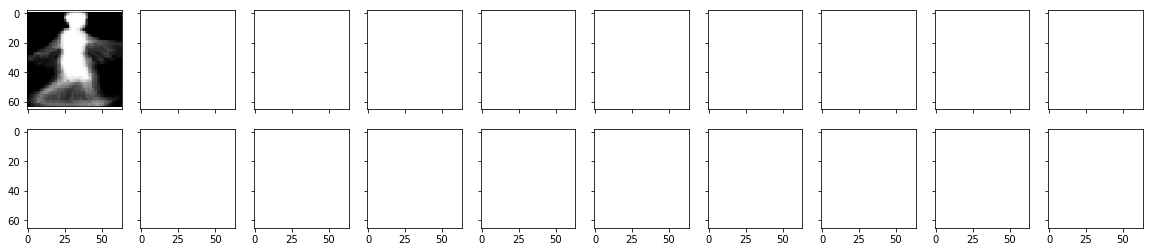

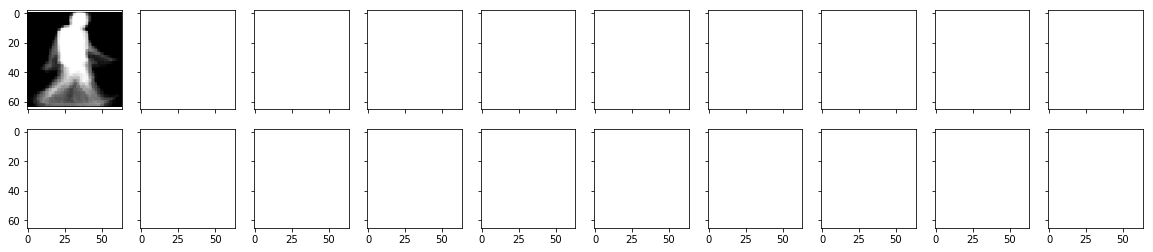


Validation loss: 0.286,  Validation accuracy: 79.829,  maxpool_3.shape: (8, 8, 8).

Epoch: 2/3000,   Iteration: 105,   Train loss: 0.292,  0.2s /batch.  Train Accuracy: %85.403
Epoch: 2/3000,   Iteration: 110,   Train loss: 0.280,  0.2s /batch.  Train Accuracy: %86.920
Epoch: 2/3000,   Iteration: 115,   Train loss: 0.278,  0.2s /batch.  Train Accuracy: %86.177
Epoch: 2/3000,   Iteration: 120,   Train loss: 0.274,  0.2s /batch.  Train Accuracy: %86.784
Epoch: 2/3000,   Iteration: 125,   Train loss: 0.269,  0.2s /batch.  Train Accuracy: %87.231


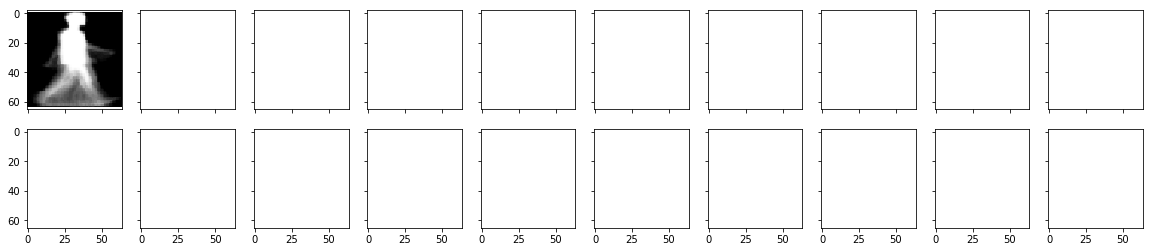

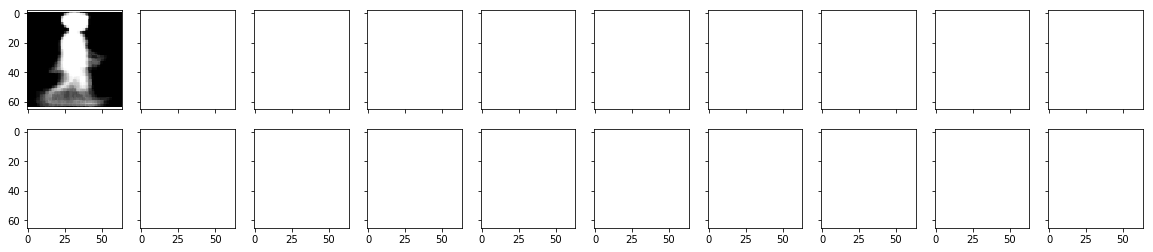

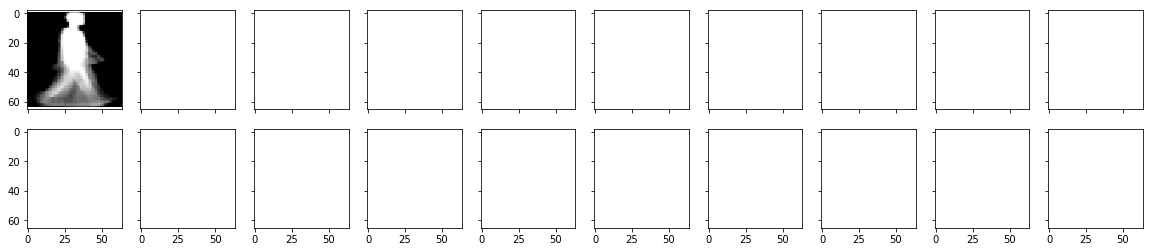

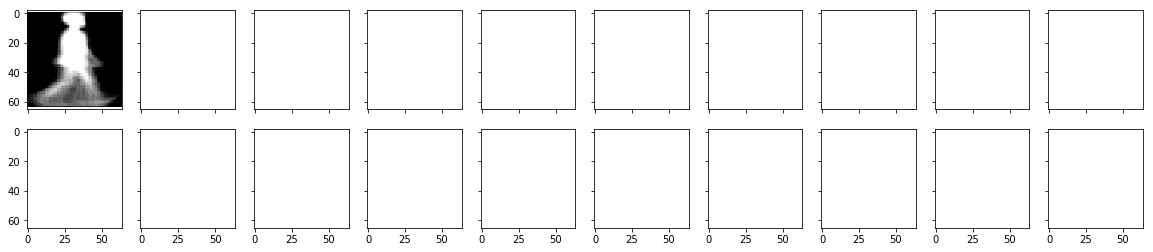

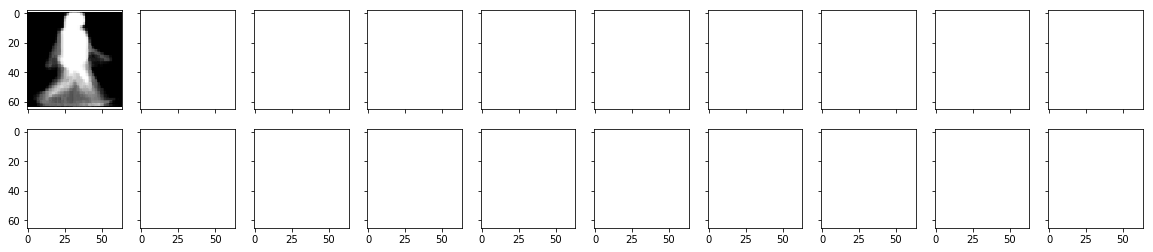

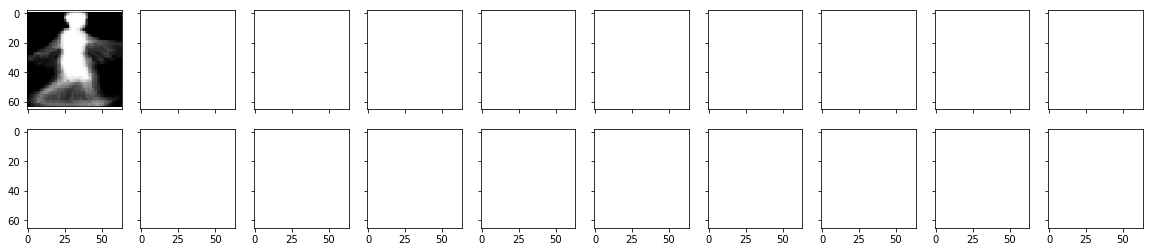

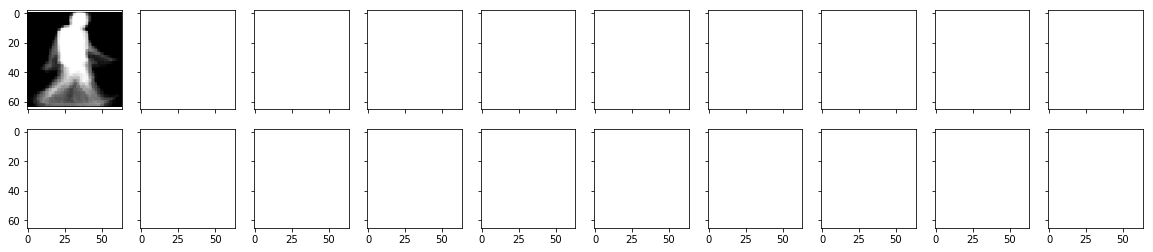


Validation loss: 0.275,  Validation accuracy: 82.458,  maxpool_3.shape: (8, 8, 8).

Epoch: 3/3000,   Iteration: 130,   Train loss: 0.273,  0.2s /batch.  Train Accuracy: %88.755
Epoch: 3/3000,   Iteration: 135,   Train loss: 0.273,  0.2s /batch.  Train Accuracy: %88.910
Epoch: 3/3000,   Iteration: 140,   Train loss: 0.268,  0.2s /batch.  Train Accuracy: %89.463
Epoch: 3/3000,   Iteration: 145,   Train loss: 0.262,  0.2s /batch.  Train Accuracy: %88.908
Epoch: 3/3000,   Iteration: 150,   Train loss: 0.260,  0.2s /batch.  Train Accuracy: %88.708


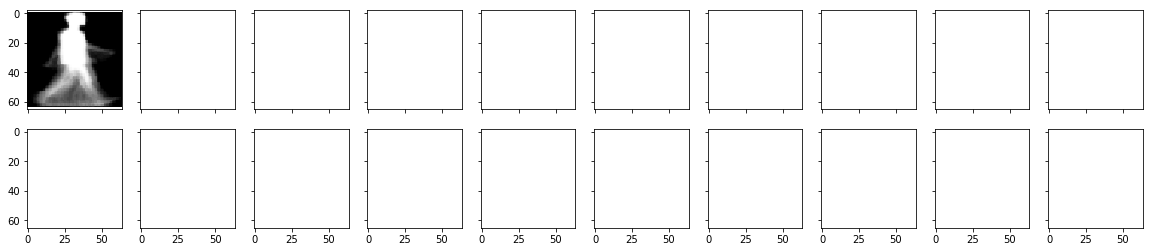

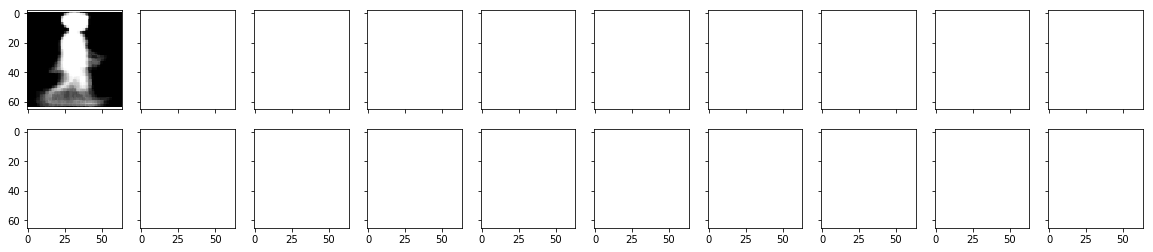

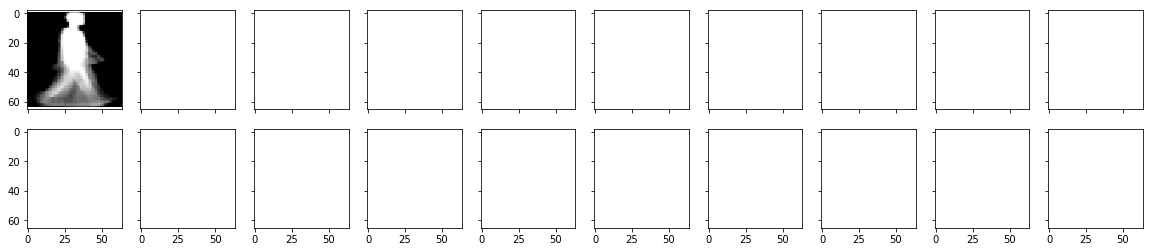

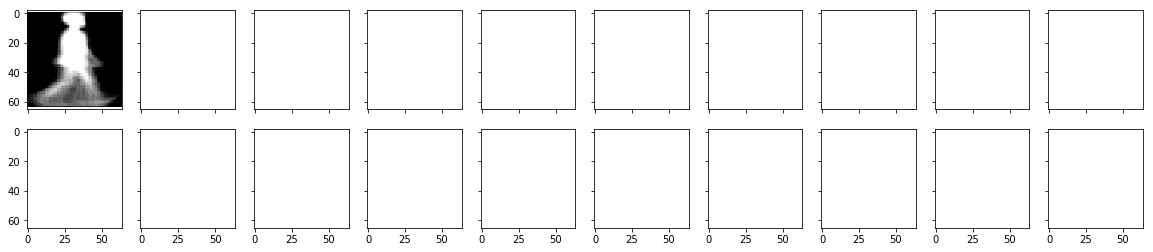

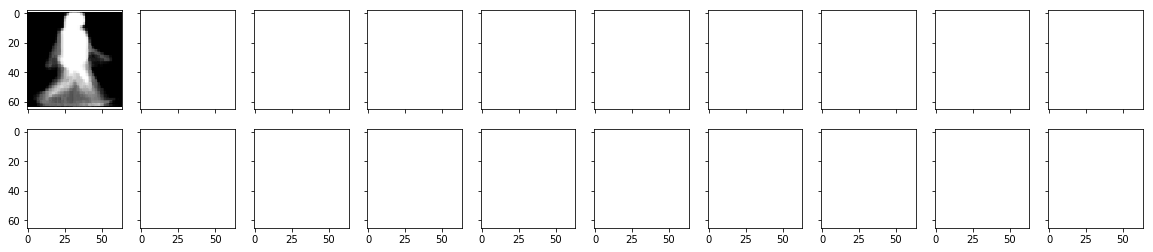

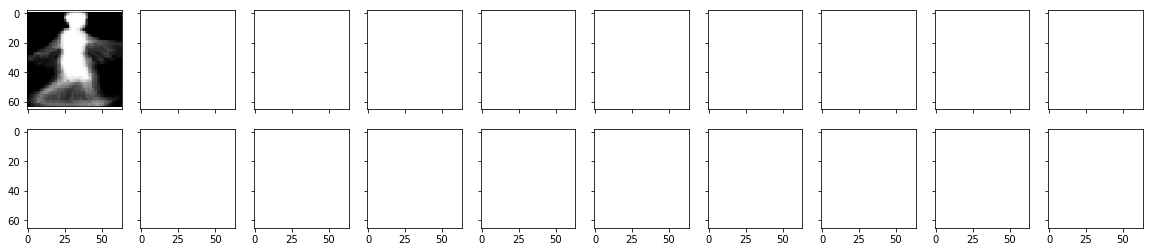

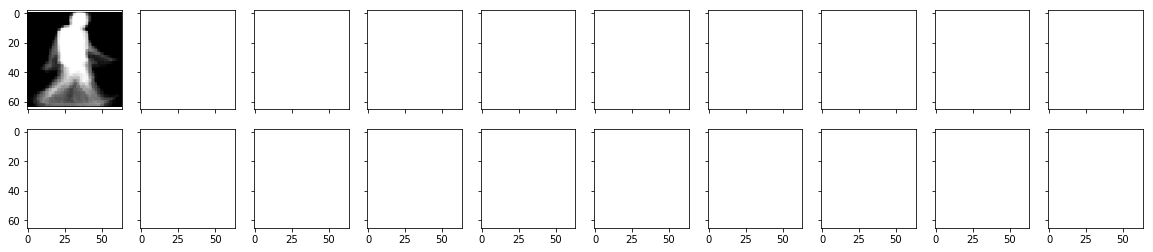


Validation loss: 0.268,  Validation accuracy: 83.584,  maxpool_3.shape: (8, 8, 8).

Epoch: 3/3000,   Iteration: 155,   Train loss: 0.262,  0.2s /batch.  Train Accuracy: %89.246
Epoch: 3/3000,   Iteration: 160,   Train loss: 0.257,  0.2s /batch.  Train Accuracy: %89.178
Epoch: 3/3000,   Iteration: 165,   Train loss: 0.268,  0.2s /batch.  Train Accuracy: %90.208
Epoch: 3/3000,   Iteration: 170,   Train loss: 0.267,  0.2s /batch.  Train Accuracy: %90.682
Epoch: 3/3000,   Iteration: 175,   Train loss: 0.263,  0.2s /batch.  Train Accuracy: %90.777


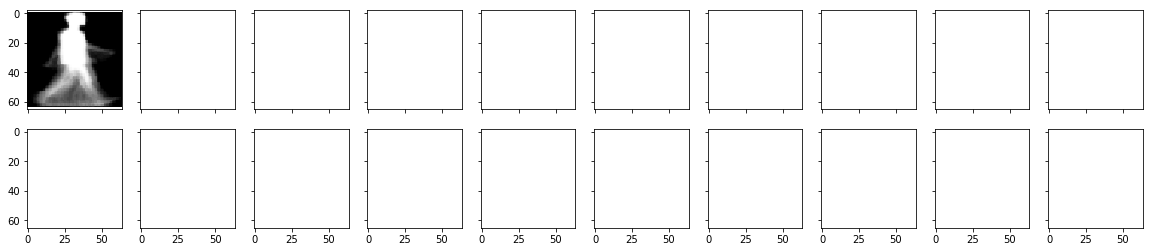

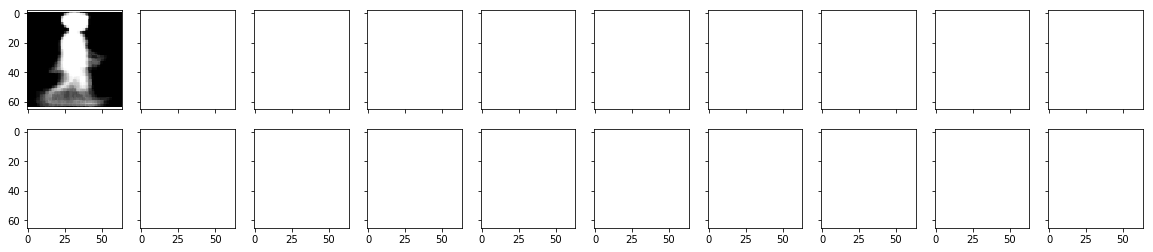

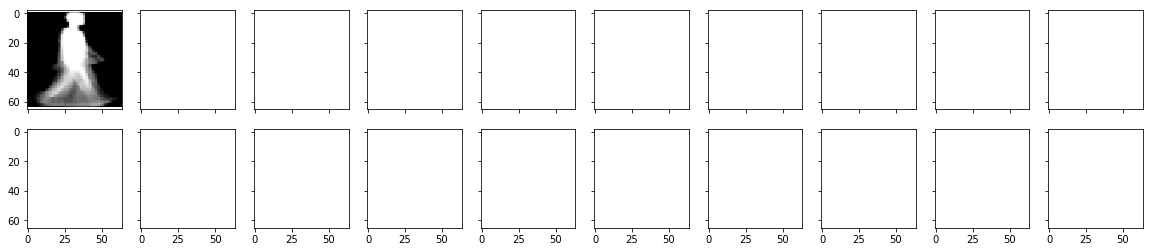

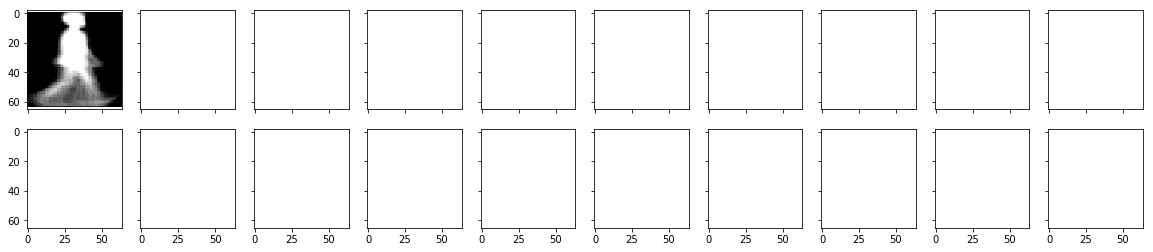

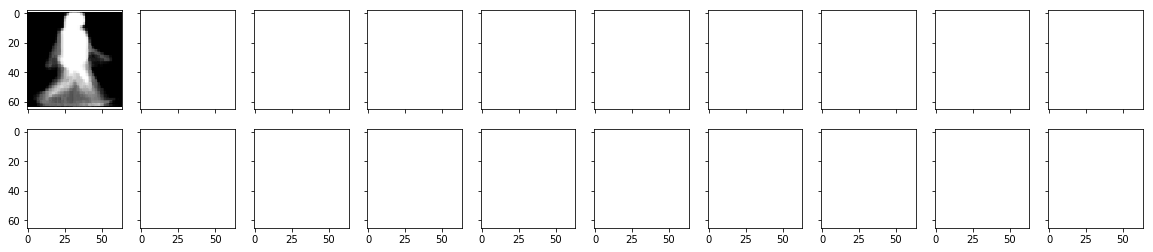

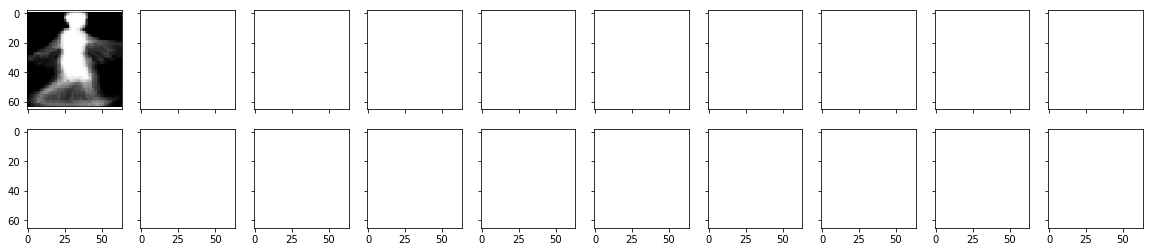

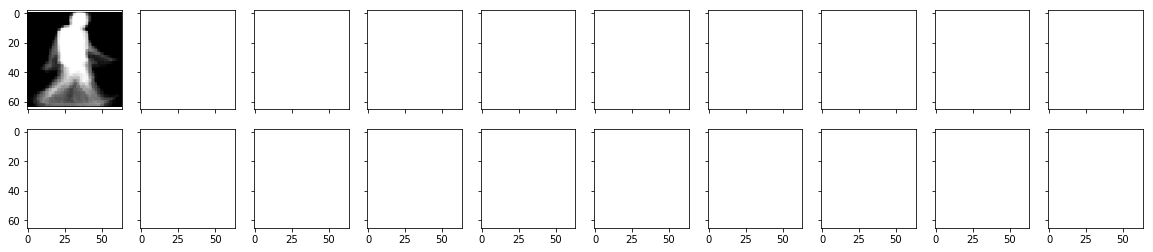


Validation loss: 0.263,  Validation accuracy: 84.585,  maxpool_3.shape: (8, 8, 8).

Epoch: 3/3000,   Iteration: 180,   Train loss: 0.255,  0.2s /batch.  Train Accuracy: %90.101
Epoch: 3/3000,   Iteration: 185,   Train loss: 0.257,  0.2s /batch.  Train Accuracy: %90.266
Epoch: 3/3000,   Iteration: 190,   Train loss: 0.259,  0.2s /batch.  Train Accuracy: %90.430
Epoch: 4/3000,   Iteration: 195,   Train loss: 0.257,  0.2s /batch.  Train Accuracy: %91.669
Epoch: 4/3000,   Iteration: 200,   Train loss: 0.258,  0.2s /batch.  Train Accuracy: %91.729


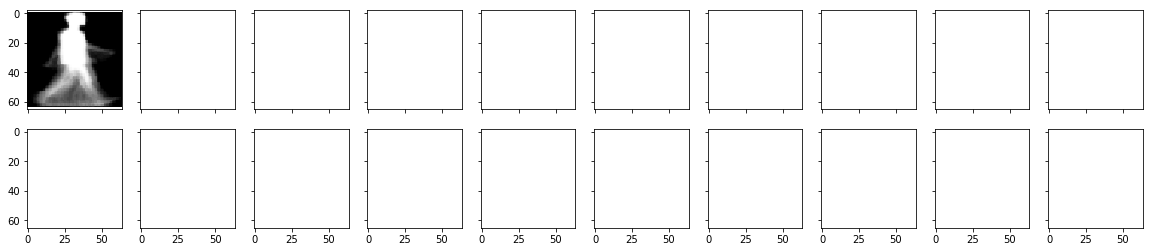

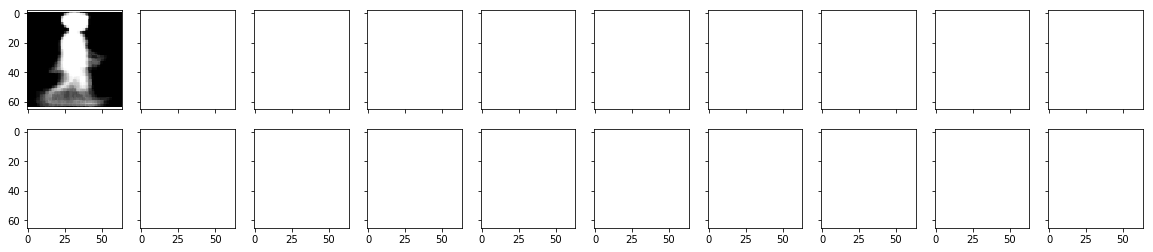

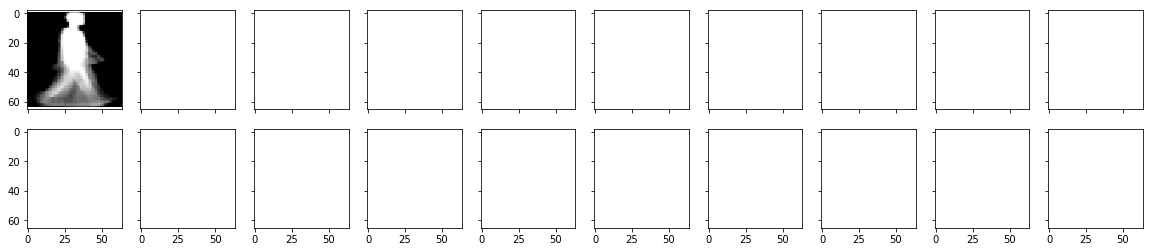

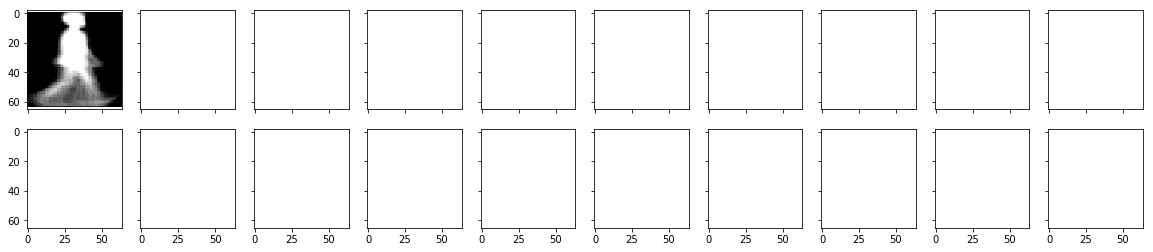

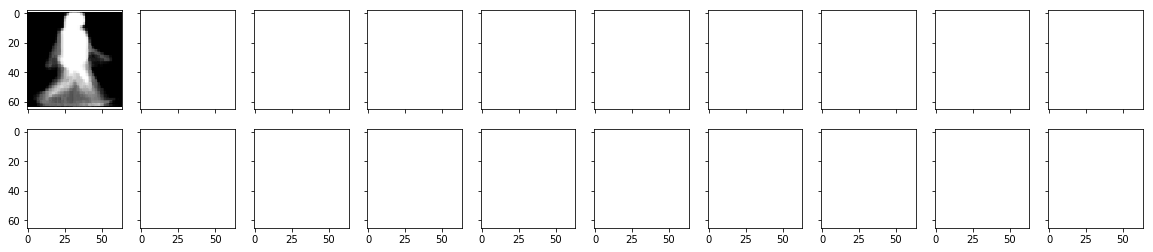

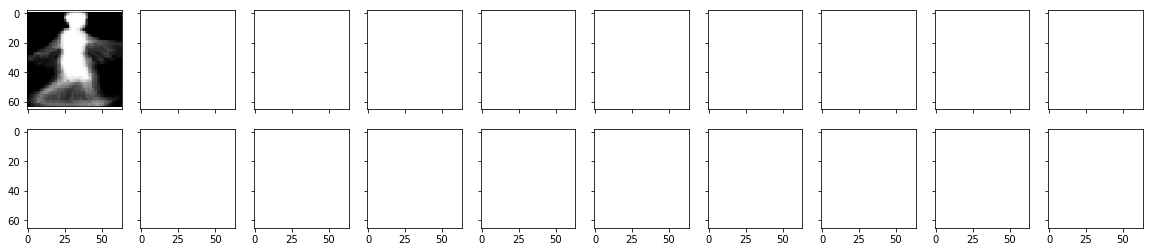

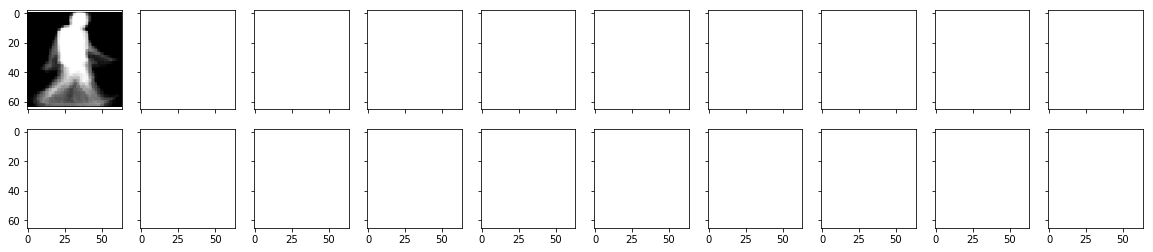


Validation loss: 0.257,  Validation accuracy: 85.929,  maxpool_3.shape: (8, 8, 8).

Epoch: 4/3000,   Iteration: 205,   Train loss: 0.254,  0.3s /batch.  Train Accuracy: %91.369
Epoch: 4/3000,   Iteration: 210,   Train loss: 0.251,  0.2s /batch.  Train Accuracy: %91.195
Epoch: 4/3000,   Iteration: 215,   Train loss: 0.250,  0.2s /batch.  Train Accuracy: %91.342
Epoch: 4/3000,   Iteration: 220,   Train loss: 0.244,  0.2s /batch.  Train Accuracy: %91.447
Epoch: 4/3000,   Iteration: 225,   Train loss: 0.249,  0.2s /batch.  Train Accuracy: %91.596


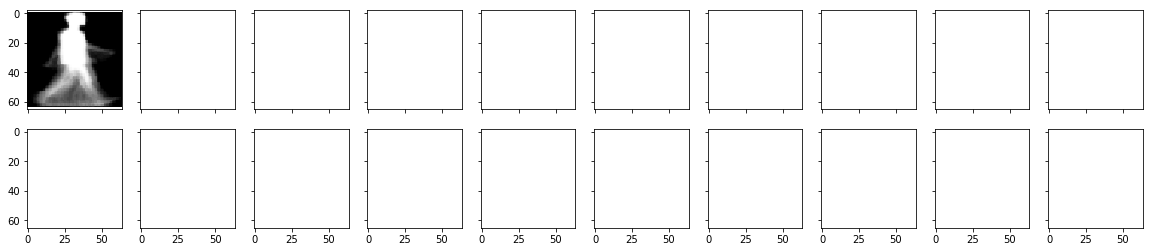

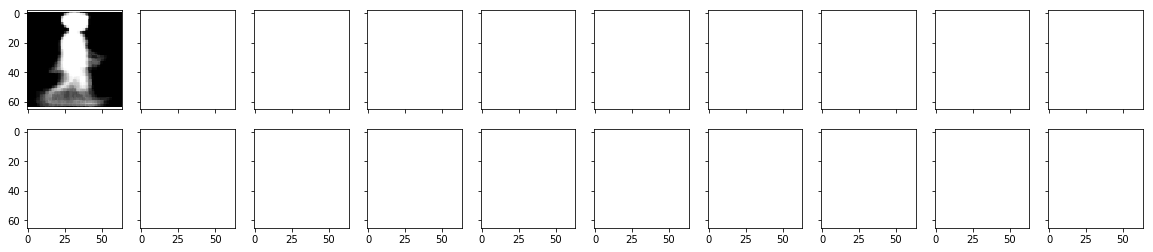

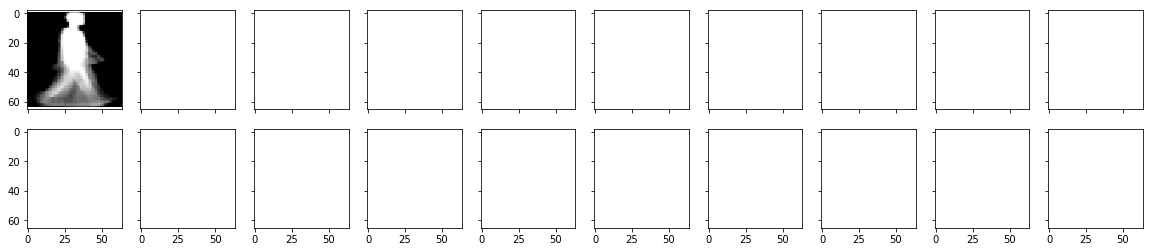

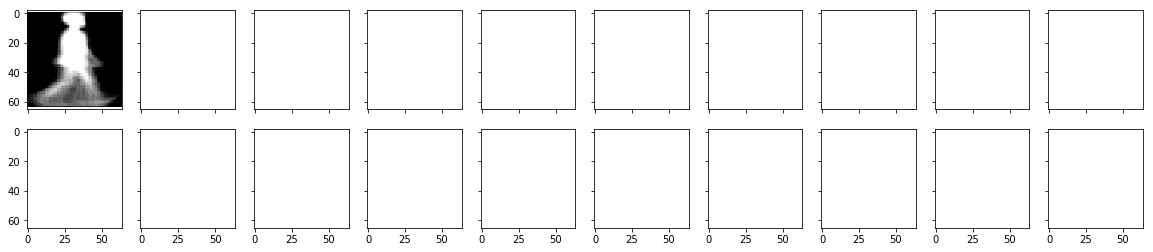

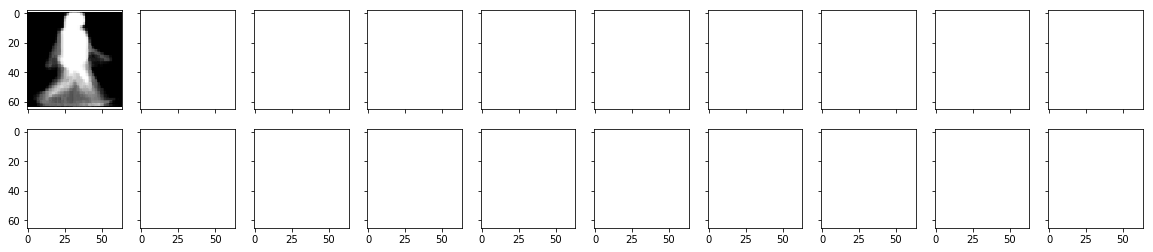

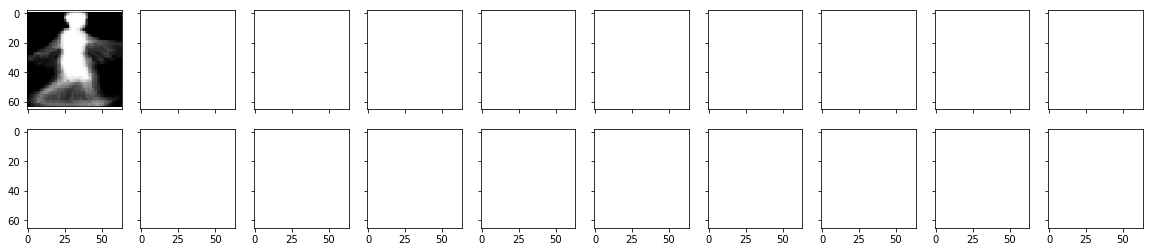

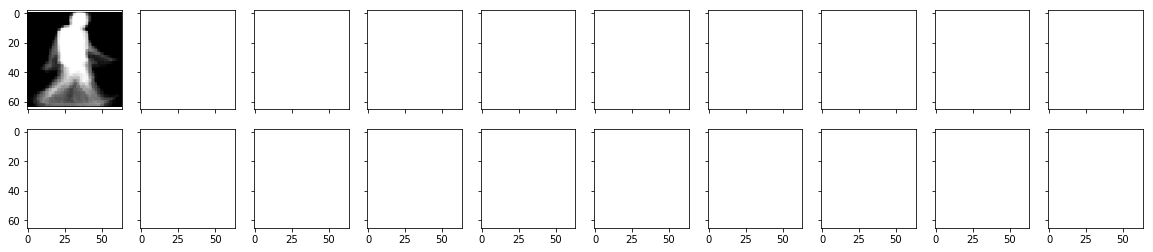


Validation loss: 0.256,  Validation accuracy: 86.295,  maxpool_3.shape: (8, 8, 8).

Epoch: 4/3000,   Iteration: 230,   Train loss: 0.258,  0.2s /batch.  Train Accuracy: %92.159
Epoch: 4/3000,   Iteration: 235,   Train loss: 0.260,  0.3s /batch.  Train Accuracy: %92.337
Epoch: 4/3000,   Iteration: 240,   Train loss: 0.249,  0.2s /batch.  Train Accuracy: %92.049
Epoch: 4/3000,   Iteration: 245,   Train loss: 0.250,  0.2s /batch.  Train Accuracy: %91.131
Epoch: 4/3000,   Iteration: 250,   Train loss: 0.248,  0.3s /batch.  Train Accuracy: %92.017


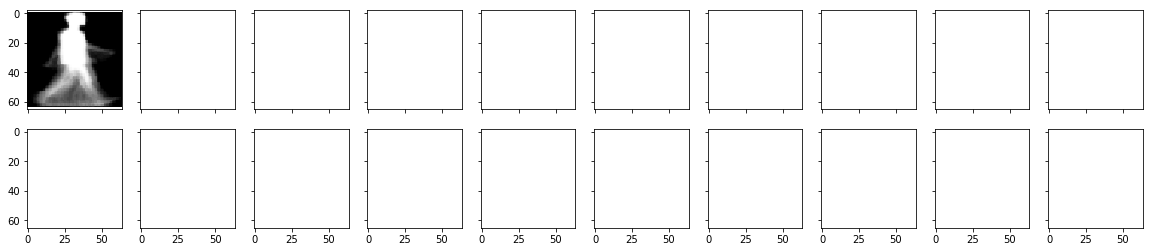

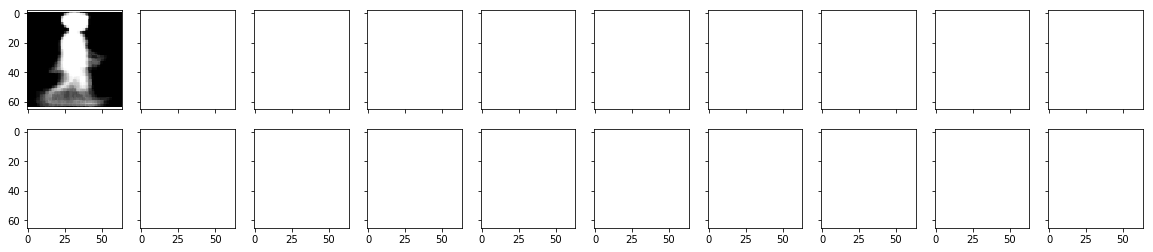

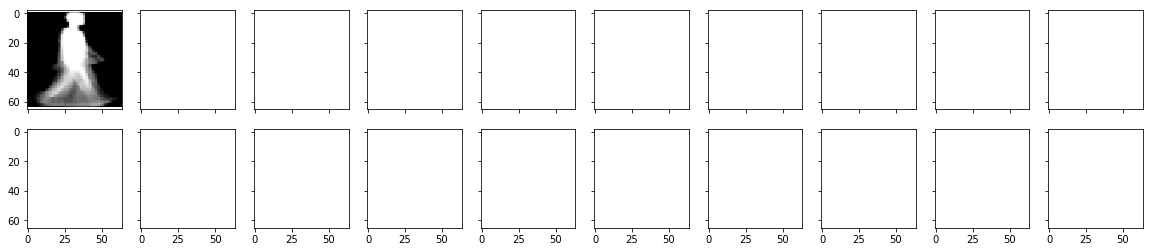

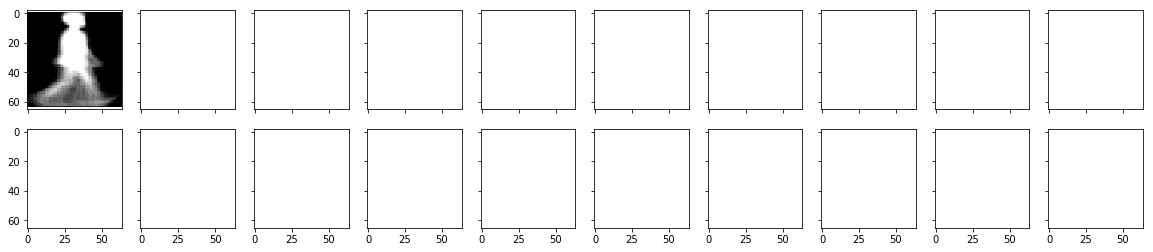

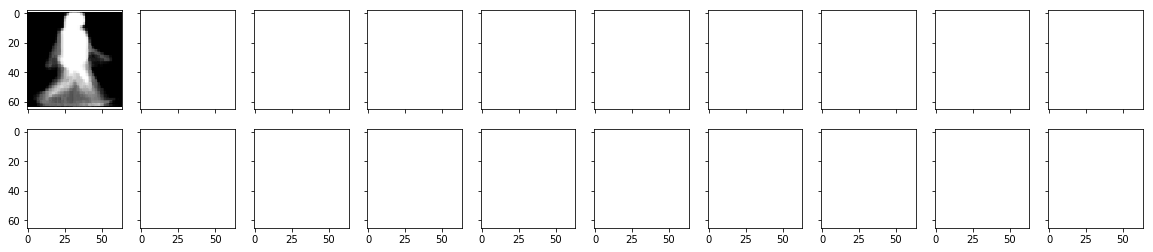

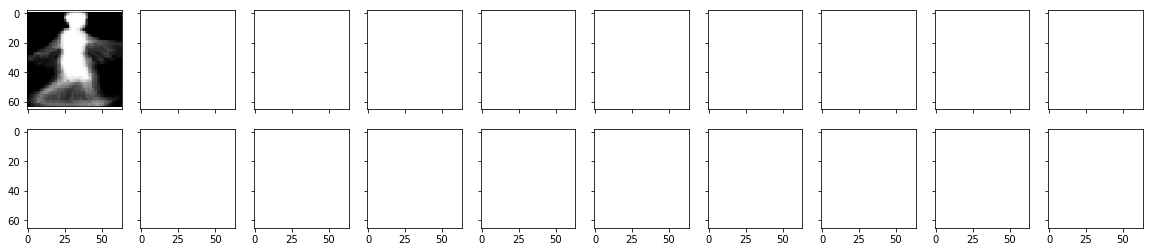

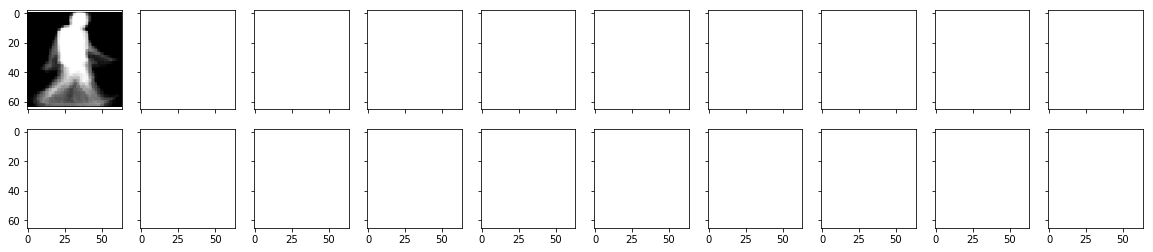


Validation loss: 0.253,  Validation accuracy: 86.269,  maxpool_3.shape: (8, 8, 8).

Epoch: 4/3000,   Iteration: 255,   Train loss: 0.249,  0.2s /batch.  Train Accuracy: %91.842
Epoch: 5/3000,   Iteration: 260,   Train loss: 0.258,  0.2s /batch.  Train Accuracy: %93.141
Epoch: 5/3000,   Iteration: 265,   Train loss: 0.256,  0.2s /batch.  Train Accuracy: %92.867
Epoch: 5/3000,   Iteration: 270,   Train loss: 0.255,  0.2s /batch.  Train Accuracy: %92.076
Epoch: 5/3000,   Iteration: 275,   Train loss: 0.247,  0.2s /batch.  Train Accuracy: %92.094


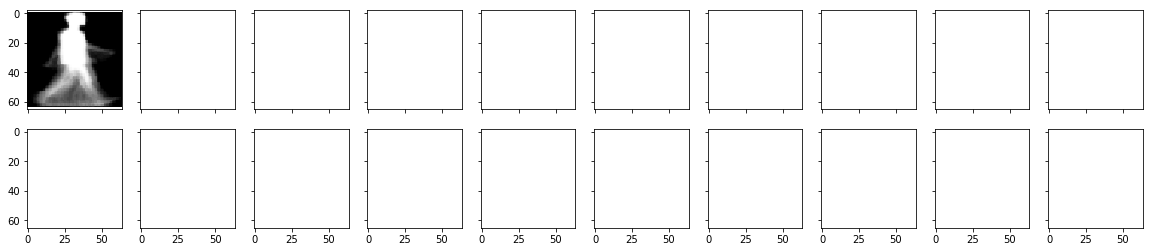

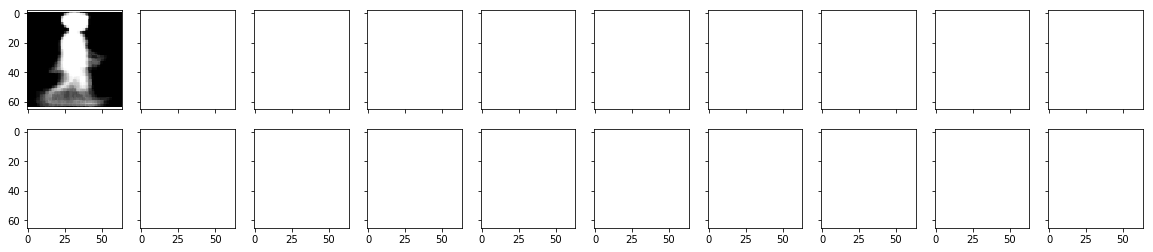

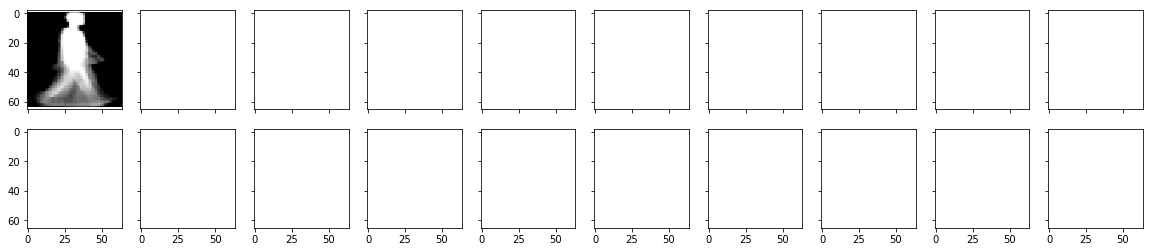

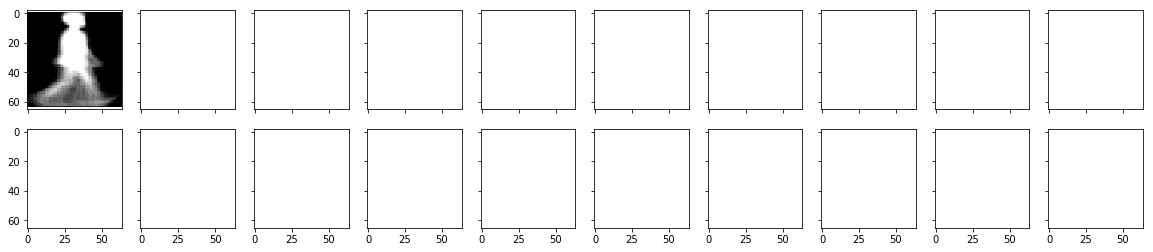

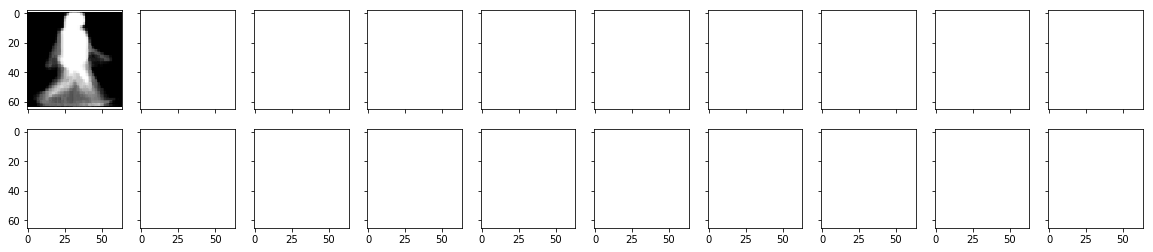

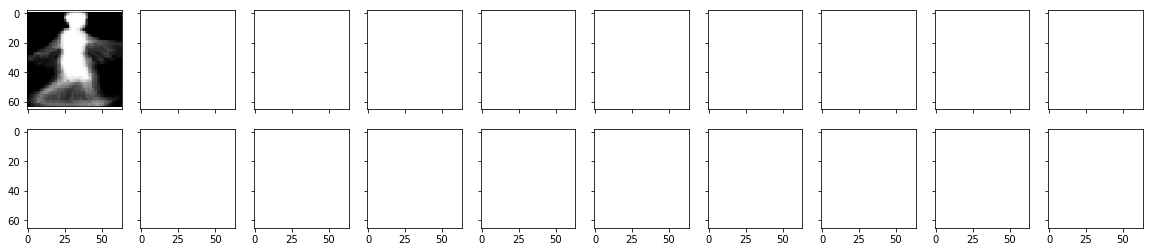

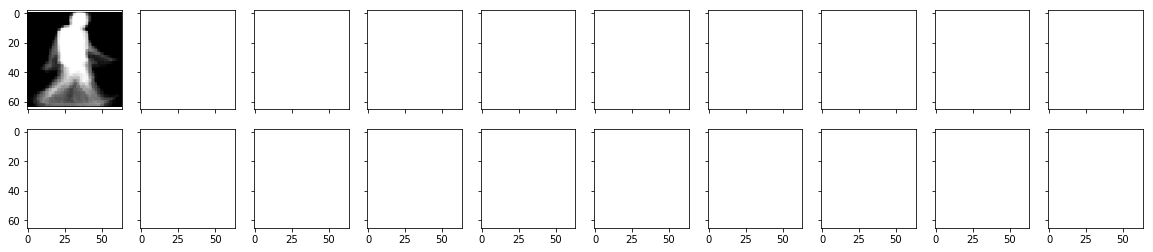


Validation loss: 0.253,  Validation accuracy: 86.193,  maxpool_3.shape: (8, 8, 8).

Epoch: 5/3000,   Iteration: 280,   Train loss: 0.248,  0.2s /batch.  Train Accuracy: %92.122
Epoch: 5/3000,   Iteration: 285,   Train loss: 0.245,  0.2s /batch.  Train Accuracy: %92.486
Epoch: 5/3000,   Iteration: 290,   Train loss: 0.254,  0.2s /batch.  Train Accuracy: %92.950
Epoch: 5/3000,   Iteration: 295,   Train loss: 0.252,  0.2s /batch.  Train Accuracy: %93.295
Epoch: 5/3000,   Iteration: 300,   Train loss: 0.250,  0.2s /batch.  Train Accuracy: %93.015


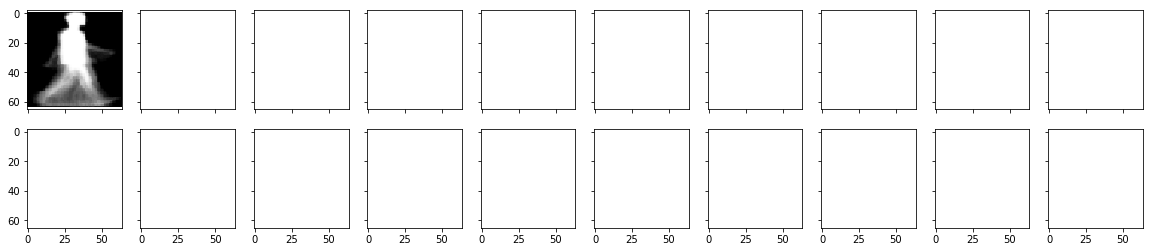

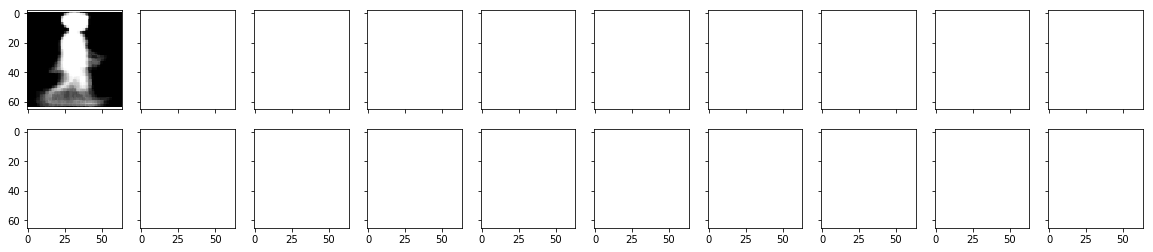

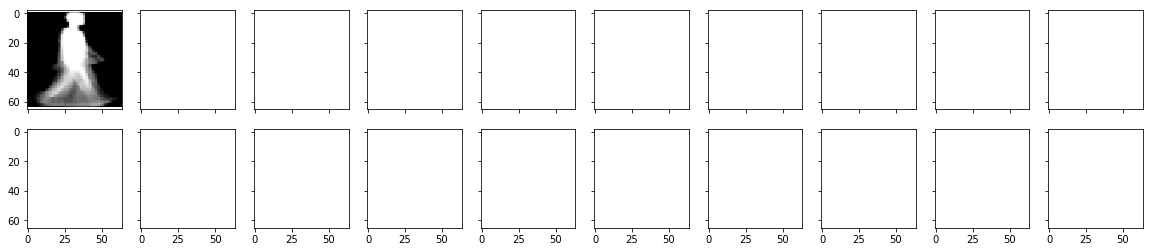

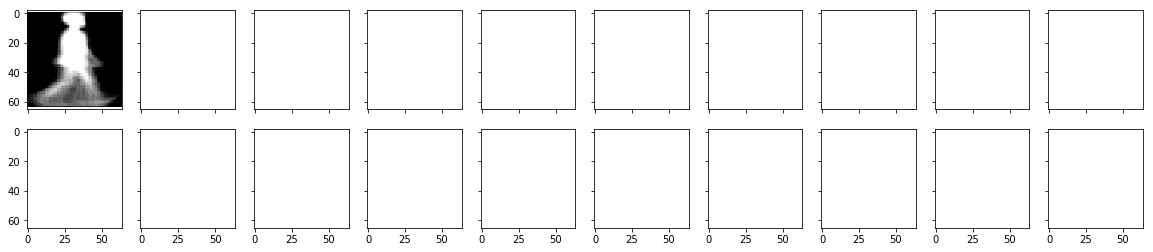

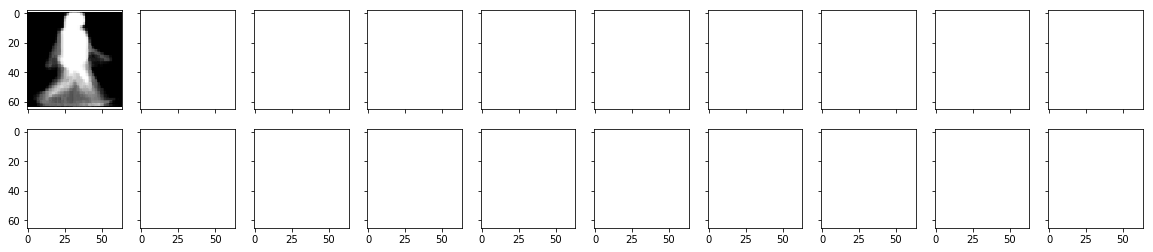

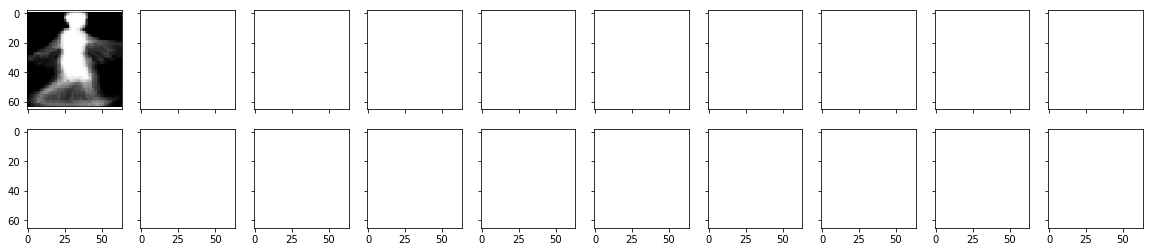

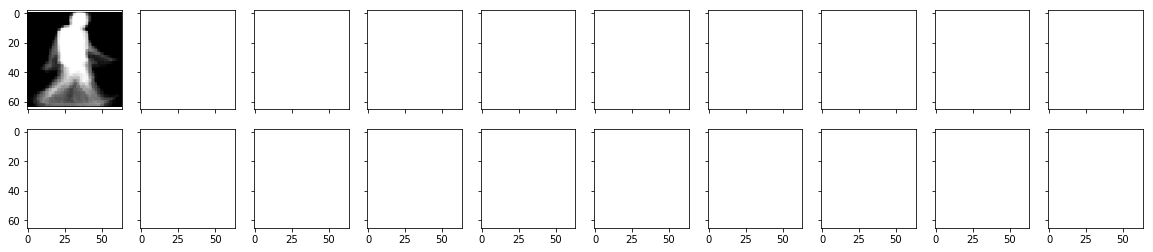


Validation loss: 0.250,  Validation accuracy: 86.912,  maxpool_3.shape: (8, 8, 8).

Epoch: 5/3000,   Iteration: 305,   Train loss: 0.245,  0.3s /batch.  Train Accuracy: %92.945
Epoch: 5/3000,   Iteration: 310,   Train loss: 0.244,  0.4s /batch.  Train Accuracy: %92.440
Epoch: 5/3000,   Iteration: 315,   Train loss: 0.246,  0.2s /batch.  Train Accuracy: %92.719
Epoch: 5/3000,   Iteration: 320,   Train loss: 0.243,  0.3s /batch.  Train Accuracy: %92.805
Epoch: 6/3000,   Iteration: 325,   Train loss: 0.248,  0.3s /batch.  Train Accuracy: %93.422


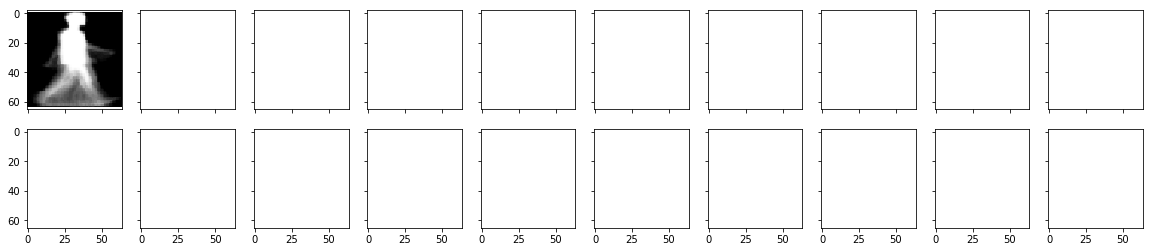

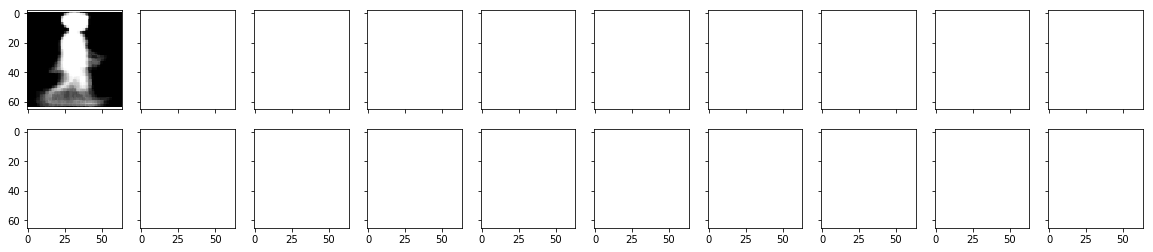

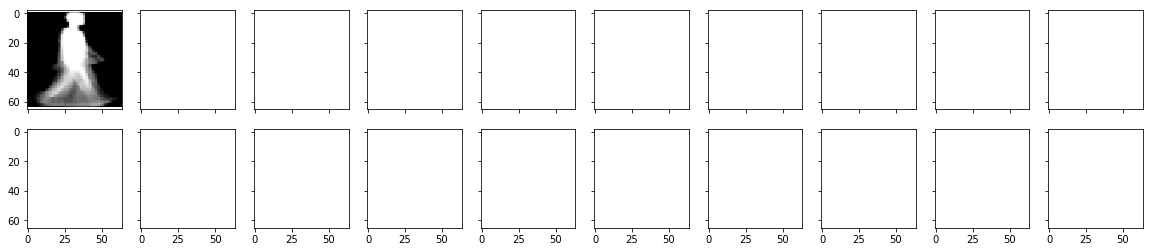

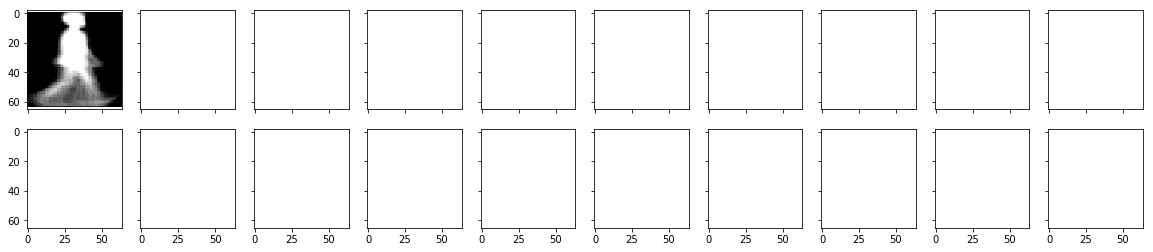

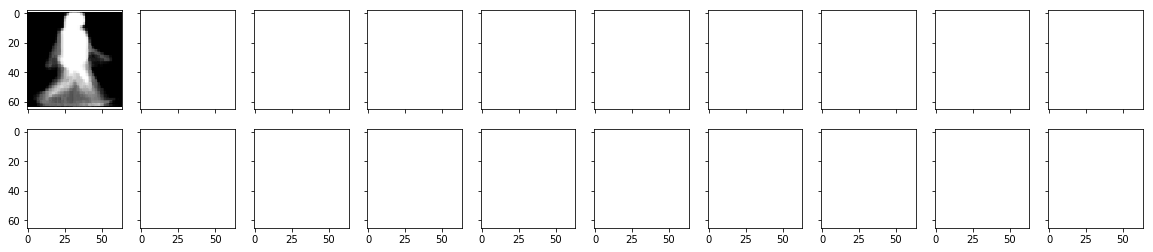

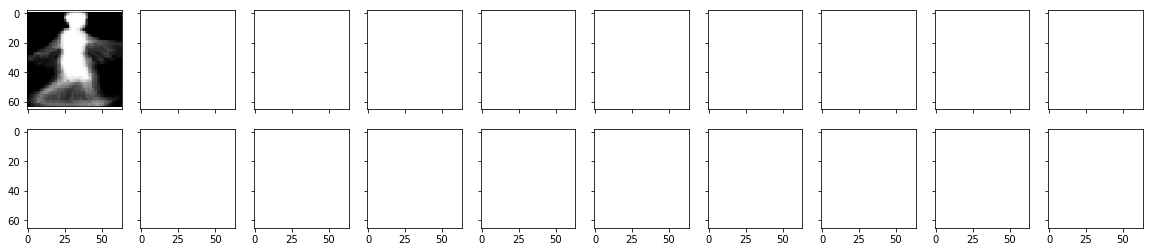

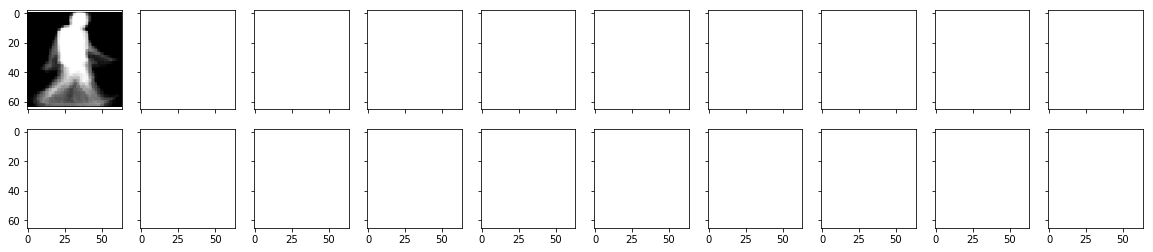


Validation loss: 0.248,  Validation accuracy: 87.678,  maxpool_3.shape: (8, 8, 8).

Epoch: 6/3000,   Iteration: 330,   Train loss: 0.245,  0.3s /batch.  Train Accuracy: %93.855
Epoch: 6/3000,   Iteration: 335,   Train loss: 0.248,  0.3s /batch.  Train Accuracy: %93.496
Epoch: 6/3000,   Iteration: 340,   Train loss: 0.239,  0.3s /batch.  Train Accuracy: %93.175
Epoch: 6/3000,   Iteration: 345,   Train loss: 0.242,  0.3s /batch.  Train Accuracy: %93.070
Epoch: 6/3000,   Iteration: 350,   Train loss: 0.240,  0.3s /batch.  Train Accuracy: %93.304


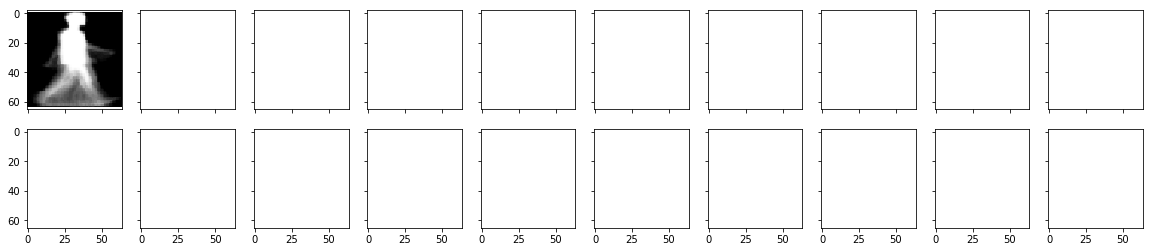

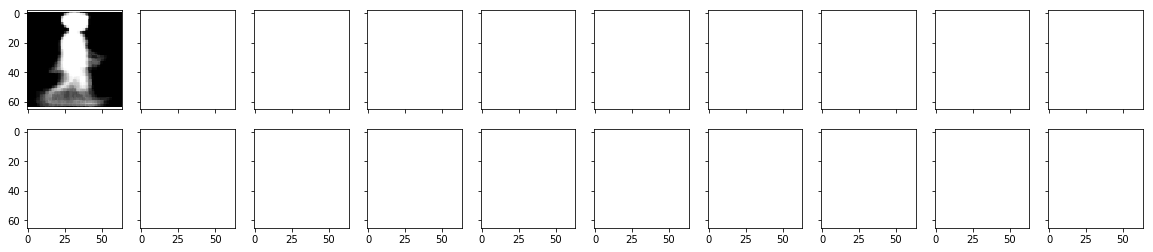

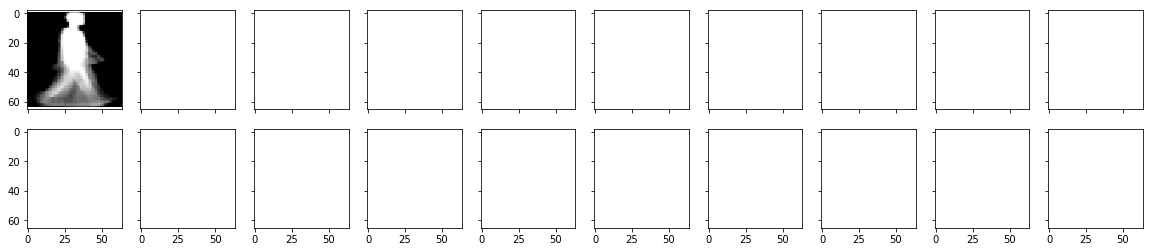

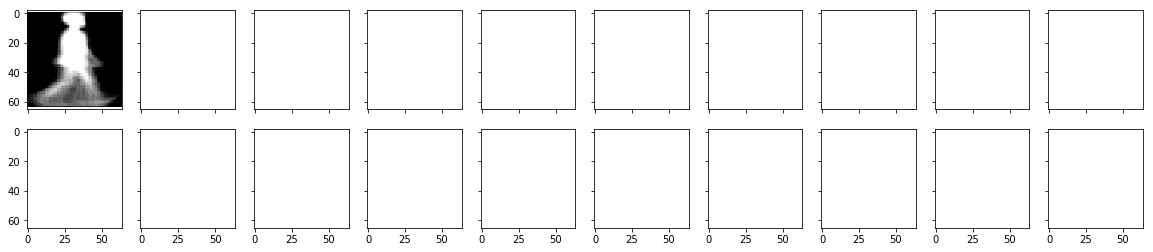

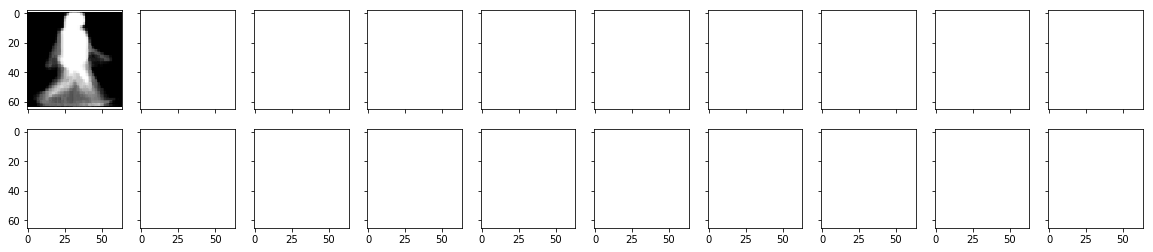

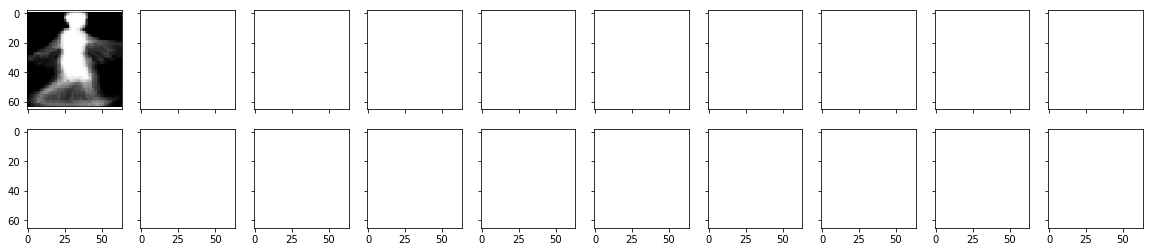

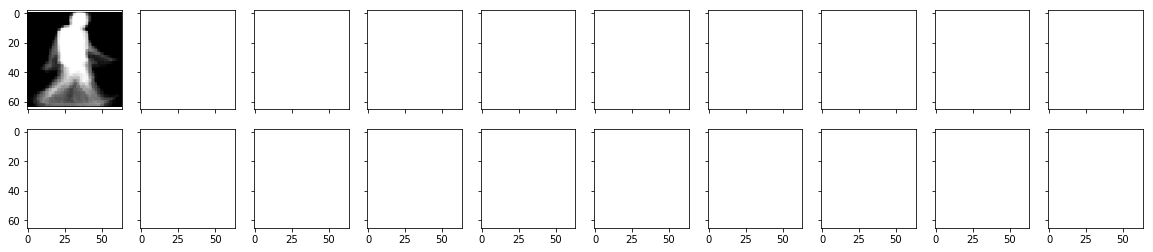


Validation loss: 0.248,  Validation accuracy: 87.582,  maxpool_3.shape: (8, 8, 8).

Epoch: 6/3000,   Iteration: 355,   Train loss: 0.251,  0.3s /batch.  Train Accuracy: %93.517
Epoch: 6/3000,   Iteration: 360,   Train loss: 0.254,  0.3s /batch.  Train Accuracy: %93.646
Epoch: 6/3000,   Iteration: 365,   Train loss: 0.243,  0.3s /batch.  Train Accuracy: %93.565
Epoch: 6/3000,   Iteration: 370,   Train loss: 0.242,  0.4s /batch.  Train Accuracy: %93.698


KeyboardInterrupt: 

In [176]:
!mkdir checkpoints_view_invariant

training = True
num_layers = 3
epochs = 3000
batch_size = 80
conv_kern_size = (3,3)
conv_strides = (1,1)
pool_size = (2,2)
pool_strides = (2,2)
up_size = [(16,16), (32,32), (64,64)]
de_kern_size = (3,3)
de_conv_strides = (1,1)
out_kern_size = (3,3)
out_strides = (1,1)

for lr in [0.0003]:
#                 log_string = 'logs/4/lr={},nl={},ls={},bs={}'.format(lr, num_layers, lstm_size, batch_size)
    save_string = './checkpoints_view_invariant\lr={}_nl={}_bs={}.ckpt'.format(lr, num_layers, batch_size)
                
#             writer = tf.summary.FileWriter(log_string)
                                
    model = build_graph(conv_kern_size, conv_strides, pool_size, pool_strides, de_kern_size, de_conv_strides,
                        out_kern_size, out_strides, up_size=up_size, is_training=training)

    train(model, epochs, save_string)
                
    print(' ')
    print(' ')
    print("leraning_rate={},num_layers={},batch_size={} finished, saved".format(lr, num_layers, batch_size))
    print(' ')
    print(' ')

<br><br><br><br><br><br><br><br><br>

## Network Architecture

The encoder part of the network will be a typical convolutional pyramid. Each convolutional layer will be followed by a max-pooling layer to reduce the dimensions of the layers. The decoder though might be something new to you. The decoder needs to convert from a narrow representation to a wide reconstructed image. For example, the representation could be a 4x4x8 max-pool layer. This is the output of the encoder, but also the input to the decoder. We want to get a 28x28x1 image out from the decoder so we need to work our way back up from the narrow decoder input layer. A schematic of the network is shown below.

<img src='assets/convolutional_autoencoder.png' width=500px>

Here our final encoder layer has size 4x4x8 = 128. The original images have size 28x28 = 784, so the encoded vector is roughly 16% the size of the original image. These are just suggested sizes for each of the layers. Feel free to change the depths and sizes, but remember our goal here is to find a small representation of the input data.

### What's going on with the decoder

Okay, so the decoder has these "Upsample" layers that you might not have seen before. First off, I'll discuss a bit what these layers *aren't*. Usually, you'll see **transposed convolution** layers used to increase the width and height of the layers. They work almost exactly the same as convolutional layers, but in reverse. A stride in the input layer results in a larger stride in the transposed convolution layer. For example, if you have a 3x3 kernel, a 3x3 patch in the input layer will be reduced to one unit in a convolutional layer. Comparatively, one unit in the input layer will be expanded to a 3x3 path in a transposed convolution layer. The TensorFlow API provides us with an easy way to create the layers, [`tf.nn.conv2d_transpose`](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d_transpose). 

However, transposed convolution layers can lead to artifacts in the final images, such as checkerboard patterns. This is due to overlap in the kernels which can be avoided by setting the stride and kernel size equal. In [this Distill article](http://distill.pub/2016/deconv-checkerboard/) from Augustus Odena, *et al*, the authors show that these checkerboard artifacts can be avoided by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer. In TensorFlow, this is easily done with [`tf.image.resize_images`](https://www.tensorflow.org/versions/r1.1/api_docs/python/tf/image/resize_images), followed by a convolution. Be sure to read the Distill article to get a better understanding of deconvolutional layers and why we're using upsampling.

> **Exercise:** Build the network shown above. Remember that a convolutional layer with strides of 1 and 'same' padding won't reduce the height and width. That is, if the input is 28x28 and the convolution layer has stride = 1 and 'same' padding, the convolutional layer will also be 28x28. The max-pool layers are used the reduce the width and height. A stride of 2 will reduce the size by 2. Odena *et al* claim that nearest neighbor interpolation works best for the upsampling, so make sure to include that as a parameter in `tf.image.resize_images` or use [`tf.image.resize_nearest_neighbor`]( `https://www.tensorflow.org/api_docs/python/tf/image/resize_nearest_neighbor). For convolutional layers, use [`tf.layers.conv2d`](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d). For example, you would write `conv1 = tf.layers.conv2d(inputs, 32, (5,5), padding='same', activation=tf.nn.relu)` for a layer with a depth of 32, a 5x5 kernel, stride of (1,1), padding is 'same', and a ReLU activation. Similarly, for the max-pool layers, use [`tf.layers.max_pooling2d`](https://www.tensorflow.org/api_docs/python/tf/layers/max_pooling2d).

## Training

As before, here wi'll train the network. Instead of flattening the images though, we can pass them in as 28x28x1 arrays.

In [6]:
sess = tf.Session()

In [ ]:
epochs = 20
batch_size = 200
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        imgs = batch[0].reshape((-1, 28, 28, 1))
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

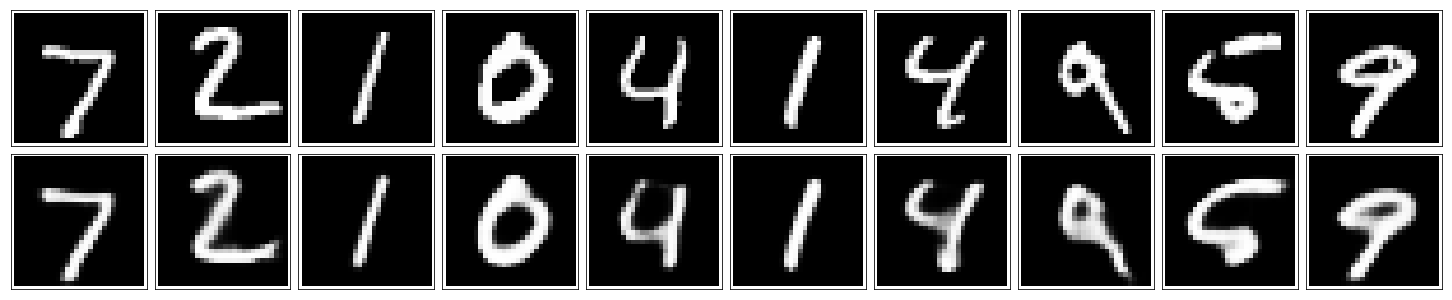

In [13]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
reconstructed = sess.run(decoded, feed_dict={inputs_: in_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


fig.tight_layout(pad=0.1)

In [19]:
sess.close()

## Denoising

As I've mentioned before, autoencoders like the ones you've built so far aren't too useful in practive. However, they can be used to denoise images quite successfully just by training the network on noisy images. We can create the noisy images ourselves by adding Gaussian noise to the training images, then clipping the values to be between 0 and 1. We'll use noisy images as input and the original, clean images as targets. Here's an example of the noisy images I generated and the denoised images.

![Denoising autoencoder](assets/denoising.png)


Since this is a harder problem for the network, we'll want to use deeper convolutional layers here, more feature maps. I suggest something like 32-32-16 for the depths of the convolutional layers in the encoder, and the same depths going backward through the decoder. Otherwise the architecture is the same as before.

> **Exercise:** Build the network for the denoising autoencoder. It's the same as before, but with deeper layers. I suggest 32-32-16 for the depths, but you can play with these numbers, or add more layers.

In [21]:
inputs_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 28, 28, 1), name='targets')

### Encoder
conv1 = tf.layers.conv2d(inputs_, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x32
maxpool1 = tf.layers.max_pooling2d(conv1, (2,2), (2,2), padding='same')
# Now 14x14x32
conv2 = tf.layers.conv2d(maxpool1, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x32
maxpool2 = tf.layers.max_pooling2d(conv2, (2,2), (2,2), padding='same')
# Now 7x7x32
conv3 = tf.layers.conv2d(maxpool2, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x16
encoded = tf.layers.max_pooling2d(conv3, (2,2), (2,2), padding='same')
# Now 4x4x16

### Decoder
upsample1 = tf.image.resize_nearest_neighbor(encoded, (7,7))
# Now 7x7x16
conv4 = tf.layers.conv2d(upsample1, 16, (3,3), padding='same', activation=tf.nn.relu)
# Now 7x7x16
upsample2 = tf.image.resize_nearest_neighbor(conv4, (14,14))
# Now 14x14x16
conv5 = tf.layers.conv2d(upsample2, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 14x14x32
upsample3 = tf.image.resize_nearest_neighbor(conv5, (28,28))
# Now 28x28x32
conv6 = tf.layers.conv2d(upsample3, 32, (3,3), padding='same', activation=tf.nn.relu)
# Now 28x28x32

logits = tf.layers.conv2d(conv6, 1, (3,3), padding='same', activation=None)
#Now 28x28x1

decoded = tf.nn.sigmoid(logits, name='decoded')

loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(0.001).minimize(cost)

In [22]:
sess = tf.Session()

In [ ]:
epochs = 100
batch_size = 200
# Set's how much noise we're adding to the MNIST images
noise_factor = 0.5
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for ii in range(mnist.train.num_examples//batch_size):
        batch = mnist.train.next_batch(batch_size)
        # Get images from the batch
        imgs = batch[0].reshape((-1, 28, 28, 1))
        
        # Add random noise to the input images
        noisy_imgs = imgs + noise_factor * np.random.randn(*imgs.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)
        
        # Noisy images as inputs, original images as targets
        batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: noisy_imgs,
                                                         targets_: imgs})

        print("Epoch: {}/{}...".format(e+1, epochs),
              "Training loss: {:.4f}".format(batch_cost))

## Checking out the performance

Here I'm adding noise to the test images and passing them through the autoencoder. It does a suprising great job of removing the noise, even though it's sometimes difficult to tell what the original number is.

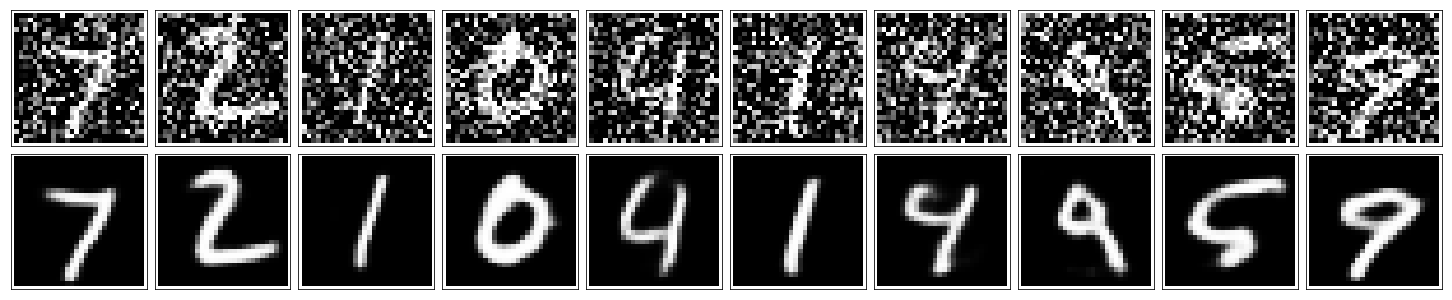

In [29]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
noisy_imgs = in_imgs + noise_factor * np.random.randn(*in_imgs.shape)
noisy_imgs = np.clip(noisy_imgs, 0., 1.)

reconstructed = sess.run(decoded, feed_dict={inputs_: noisy_imgs.reshape((10, 28, 28, 1))})

for images, row in zip([noisy_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

fig.tight_layout(pad=0.1)